# Zielscheibenvariation

In [1]:
!git clone https://github.com/ClonedPoro/HammerProjekt.git
!pip install scikit-posthocs
!pip install pingouin

Cloning into 'HammerProjekt'...
remote: Enumerating objects: 3236, done.
remote: Counting objects: 100% (708/708), done.
remote: Compressing objects: 100% (421/421), done.
remote: Total 3236 (delta 288), reused 694 (delta 284), pack-reused 2528
Receiving objects: 100% (3236/3236), 907.86 MiB | 17.18 MiB/s, done.
Resolving deltas: 100% (1523/1523), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 4.2 MB/s eta 0:00:00


**0. Nötige Packages importieren**


In [2]:
# import
import pandas as pd
import os
import seaborn as sb
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from posix import remove
import re
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from statsmodels.formula.api import ols
from scikit_posthocs import posthoc_wilcoxon
from pingouin import pairwise_gameshowell
import warnings

warnings.filterwarnings("ignore")

# Bis hier hin alles ausführen, ab hier aber bitte nichts mehr ausführen

**1. Laden der Daten**

Methode um csv Daten in das Programm zu laden. Es kommt vor dass eine nicht angezeigte Datei ".ipynb_checkpoints" detecktiert wird. Indem fall muss der Boolean "remove" auf True gesetzt werden.

In [ ]:
def load_data(path, remove, drop):
  # Liste aller Dateien im Verzeichnis
  files = os.listdir(path)
  if remove == True:
    files.remove('.ipynb_checkpoints')

  # Anzahl der Dateien im Ordner ZV (Zielscheibenvariation)
  nr_files = len(files)

  # erstellen leerer Liste
  data_list = [None] * nr_files

  # load data into lists
  for file in range(len(files)):
      data_list[file] = pd.read_csv(path + '/' + files[file], sep=";", decimal=",")

      if drop == True:
        data_list[file] = data_list[file].drop([0])

  return data_list

Laden der Treffer

In [ ]:
# HV-VR
zv_vr_raw = load_data(path = '/content/HammerProjekt/Ergebnisse/ZV_VR', remove = False, drop = True)

# HV-Real
zv_real_raw = load_data(path = '/content/HammerProjekt/Ergebnisse/ZV_Real', remove = False, drop = True)

merged_data_vr = pd.concat(zv_vr_raw)
merged_data_real = pd.concat(zv_real_raw)

merged_data_real["mode"] = "Real"


merged_data_vr.rename(columns={' x [mm]': 'x [mm]'}, inplace = True)
merged_data_real.rename(columns={' x [mm]': 'x [mm]'}, inplace = True)

del merged_data_vr["timecode"]

merged_data_vr["mode"] = "VR"
merged_data_real["mode"] = "Real"

merged_data = pd.concat([merged_data_vr, merged_data_real], ignore_index=True)

merged_data["position"] = merged_data["position"].astype(int).astype(str)

**2. Demographische Daten**

In [ ]:
demography = pd.read_csv("/content/HammerProjekt/Ergebnisse/zv_fragebogen.csv")

# Demographische Daten
print("Verteilung Geschlecht: \n", demography["Bitte geben Sie ihr Geschlecht an."].value_counts(normalize = True), "\n")
print("Mittelwert Alter: ", demography["Bitte nennen Sie ihr Alter (in Jahren)."].mean())
print("Standardabweichung Alter: ", demography["Bitte nennen Sie ihr Alter (in Jahren)."].std(), "\n")

print("Mittelwert Körpergröße: ", demography["Bitte geben Sie Ihre Größe an (in cm). "].mean())
print("Standardabweichung Körpergröße: ", demography["Bitte geben Sie Ihre Größe an (in cm). "].std(), "\n")

print("Mittelwert handwerkliche Fähigkeiten: ", demography['Wie schätzen Sie Ihre handwerklichen Fähigkeiten ein?\nMeine handwerklichen Fähigkeiten sind ... '].mean())
print("Standardabweichung handwerkliche Fähigkeiten: ", demography['Wie schätzen Sie Ihre handwerklichen Fähigkeiten ein?\nMeine handwerklichen Fähigkeiten sind ... '].std(), "\n")

print("\n \n \n")

replacer_technikaffinitaet = {"stimmt gar nicht": 1, "stimmt weitgehend nicht": 2, "stimmt eher nicht": 3, "stimmt eher": 4, "stimmt weitgehend": 5, "stimmt völlig": 6}

replacer_cybersickness = {"gar nicht": 1, "leicht": 2, "mäßig": 3, "stark": 4}

# Subsets für die einzelnen Fragebögen bilden
technikaffinitaet = demography.loc[:, 'Bitte geben Sie den Grad Ihrer Zustimmung zu folgenden Aussagen an.  [Ich beschäftige mich gern genauer mit technischen Systemen.]':'Bitte geben Sie den Grad Ihrer Zustimmung zu folgenden Aussagen an.  [Ich versuche, die Möglichkeiten eines technischen Systems vollständig auszunutzen.]'].replace(replacer_technikaffinitaet)
presence = demography.loc[:, "Auf einer Skala von 1-10 wie sehr fühlten Sie sich in der Anwendung präsent, als wären sie wirklich dort? "]
cybersickness = demography.loc[:, "Dieser Fragebogen beinhaltet eine Liste von Symptomen, die nach dem Benutzen eines Head-Mounts-Displays auftreten können. Bitte geben Sie für jedes Symptom an, wie stark es jetzt gerade bei Ihnen auftritt.  [Allgemeines Unwohlsein]":'Dieser Fragebogen beinhaltet eine Liste von Symptomen, die nach dem Benutzen eines Head-Mounts-Displays auftreten können. Bitte geben Sie für jedes Symptom an, wie stark es jetzt gerade bei Ihnen auftritt.  [Aufstoßen]'].replace(replacer_cybersickness)

# Fragebogen zur Technikaffinität
for question in technikaffinitaet:
  print(technikaffinitaet[question].describe(), "\n")

print("\n \n \n")

print(presence.describe(), "\n")

print("\n \n \n")

# Fragebogen zur Cybersickness
for question in cybersickness:
  print(cybersickness[question].describe(), "\n")

Verteilung Geschlecht: 
 weiblich    0.545455
männlich    0.454545
Name: Bitte geben Sie ihr Geschlecht an., dtype: float64 

Mittelwert Alter:  26.03030303030303
Standardabweichung Alter:  9.315594614961679 

Mittelwert Körpergröße:  171.15151515151516
Standardabweichung Körpergröße:  10.08439763979861 

Mittelwert handwerkliche Fähigkeiten:  3.727272727272727
Standardabweichung handwerkliche Fähigkeiten:  1.3293026196263418 


 
 

count    33.000000
mean      3.424242
std       1.581738
min       1.000000
25%       2.000000
50%       3.000000
75%       5.000000
max       6.000000
Name: Bitte geben Sie den Grad Ihrer Zustimmung zu folgenden Aussagen an.  [Ich beschäftige mich gern genauer mit technischen Systemen.], dtype: float64 

count    33.000000
mean      3.818182
std       1.467450
min       1.000000
25%       3.000000
50%       4.000000
75%       5.000000
max       6.000000
Name: Bitte geben Sie den Grad Ihrer Zustimmung zu folgenden Aussagen an.  [Ich probiere gern die Funkt

**3. Analyse der Treffer in den Umgebungen der Zielscheibenvariation**


Plot der Verteilung von X gegen y der Treffer in VR

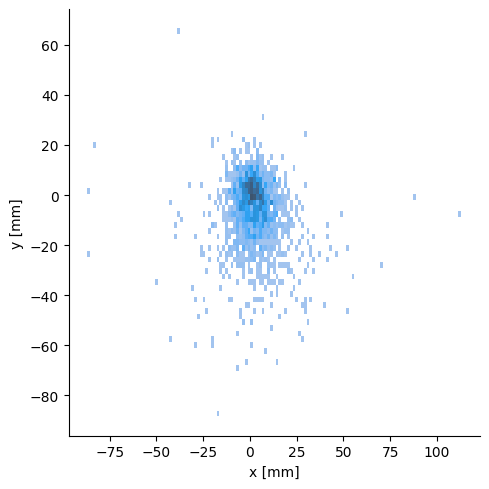

In [ ]:
#distribution plot with color-coding
sb.displot(data=merged_data_vr, x="x [mm]", y="y [mm]", legend=True)

Ausgeben der eschreibenden Werte für x [mm]

In [ ]:
print("Descriptive values for x [mm]:\n", merged_data_vr.iloc[:,6].describe(), "\n")

Descriptive values for x [mm]:
 count    2052.000000
mean        2.409585
std        10.545442
min       -86.958190
25%        -2.608288
50%         2.060347
75%         6.976249
max       113.006400
Name: x [mm], dtype: float64 



Ausgeben der beschreibenden Werte für y [mm]

In [ ]:
print("Descriptive values for y [mm]:\n", merged_data_vr.iloc[:,7].describe(), "\n")

Descriptive values for y [mm]:
 count    2052.000000
mean       -5.657597
std        12.758818
min       -88.322460
25%       -11.703902
50%        -3.258742
75%         2.867834
max        66.490110
Name: y [mm], dtype: float64 



Ausgeben der beschreibenden Werte für die Distanz des Treffers zum Mittelpunkt (0,0) in mm

In [ ]:
print("Descriptive values for distance [mm]:\n", merged_data_vr.iloc[:,8].describe())

Descriptive values for distance [mm]:
 count    2052.000000
mean       13.320473
std        11.589013
min         0.260168
25%         6.078791
50%        10.299985
75%        16.592343
max       113.300800
Name: distance [mm], dtype: float64


Histogramm der Verteilung der X-Koordinate der Treffer

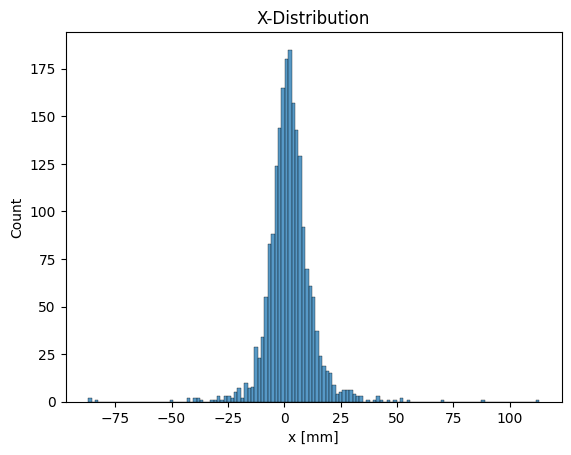

In [ ]:
sb.histplot(data=merged_data_vr, x="x [mm]")
plt.title("X-Distribution")
plt.show()

Boxplot der verteilten Daten

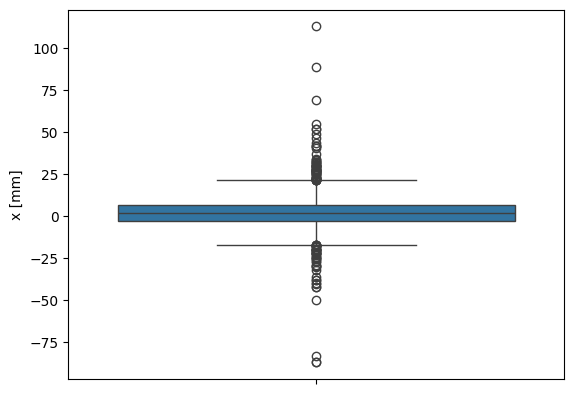

In [ ]:
plt.clf()
sb.boxplot(merged_data_vr['x [mm]'])
plt.show()

Histogramm der Verteilung der Y-Koordinate der Treffer

Text(0.5, 1.0, 'Y-Distribution')

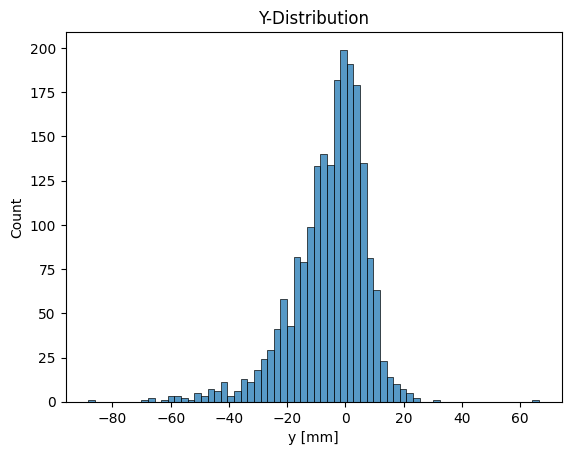

In [ ]:
sb.histplot(data=merged_data_vr, x="y [mm]")
plt.title("Y-Distribution")

Boxplot der verteilten Daten

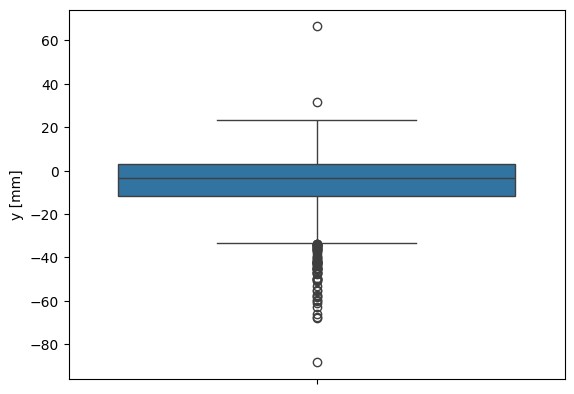

In [ ]:
plt.clf()
sb.boxplot(merged_data_vr['y [mm]'])
plt.show()

Shapiro-Wilk Test für die X-Koordinaten der Treffer

In [ ]:
print("Shapiro-Wilk Test for x-values: ", stats.shapiro(merged_data_vr.iloc[:,6]))

Shapiro-Wilk Test for x-values:  ShapiroResult(statistic=0.8579486608505249, pvalue=1.387492871854289e-39)


Shapiro-Wilk Test für die Y-Koordinaten der Treffer

In [ ]:
print("Shapiro-Wilk Test for y-values: ", stats.shapiro(merged_data_vr.iloc[:,7]))

Shapiro-Wilk Test for y-values:  ShapiroResult(statistic=0.9271930456161499, pvalue=1.8384633845730588e-30)


Levene-Test für x-y-Wert-Varianzen

In [ ]:
print("Levene Test for x-y-value variances: ", stats.levene(merged_data_vr.iloc[:,6], merged_data_vr.iloc[:,7]))

Levene Test for x-y-value variances:  LeveneResult(statistic=86.41388778795417, pvalue=2.3101623941309193e-20)


**3. Analyse der Teffer in der realen Umgebung aus der Studie der verschiedenen Zielscheibenpositionen**

Laden der VR-Treffer

Plot der Verteilung von X gegen Y der Treffer in Real

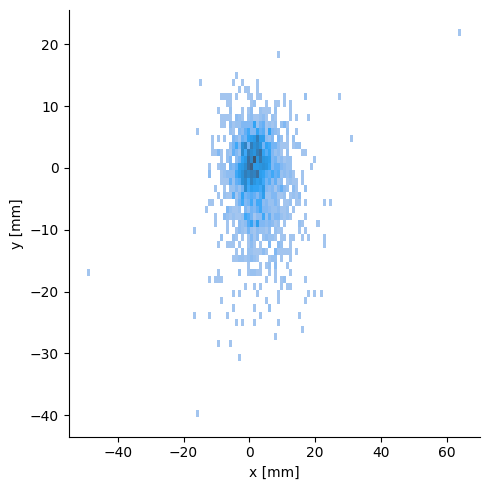

In [ ]:
#distribution plot with color-coding
sb.displot(data=merged_data_real, x = "x [mm]", y="y [mm]", legend=True)

Ausgeben der beschreibenden Werte für x [mm]

In [ ]:
print("Descriptive values for x [mm]:\n", merged_data_real.iloc[:,4].describe(), "\n")

Descriptive values for x [mm]:
 count    2062.000000
mean        2.205577
std         5.555084
min       -49.280000
25%        -0.840000
50%         1.820000
75%         5.040000
max        64.400000
Name: x [mm], dtype: float64 



Ausgeben der beschreibenden Werte für y [mm]

In [ ]:
print("Descriptive values for y [mm]:\n", merged_data_real.iloc[:,5].describe(), "\n")

Descriptive values for y [mm]:
 count    2062.000000
mean       -1.429534
std         6.382285
min       -40.320000
25%        -4.620000
50%        -0.420000
75%         2.660000
max        22.400000
Name: y [mm], dtype: float64 



Ausgeben der beschreibenden Werte für die Distanz des Treffers zum Mittelpunkt (0,0) in mm

In [ ]:
print("Descriptive values for distance [mm]:\n", merged_data_real.iloc[:,6].describe())

Descriptive values for distance [mm]:
 count    2062.000000
mean        7.115237
std         5.277581
min         0.000000
25%         3.577541
50%         5.894981
75%         9.266477
max        68.184456
Name: distance [mm], dtype: float64


Histogramm der Verteilung der X-Koordinate der Treffer

Text(0.5, 1.0, 'X-Distribution')

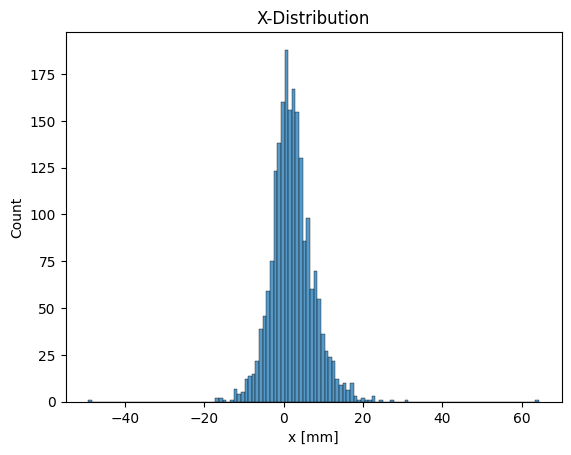

In [ ]:
sb.histplot(data=merged_data_real, x= "x [mm]")
plt.title("X-Distribution")

Boxplot der x-Verteilung der realen Daten

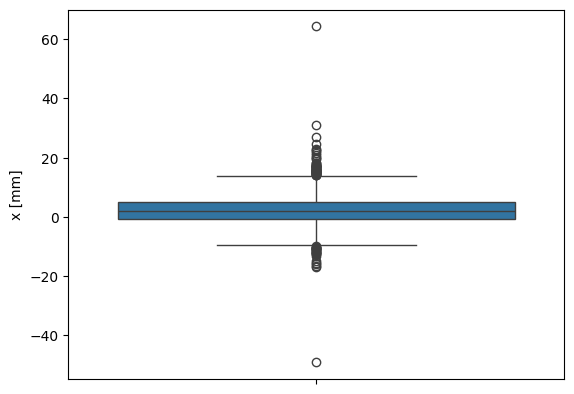

In [ ]:
plt.clf()
sb.boxplot(merged_data_real['x [mm]'])
plt.show()

Histogramm der Verteilung der Y-Koordinate der Treffer

Text(0.5, 1.0, 'Y-Distribution')

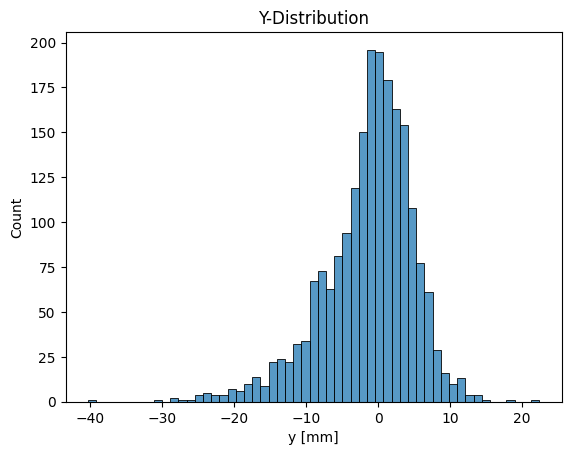

In [ ]:
sb.histplot(data=merged_data_real, x="y [mm]")
plt.title("Y-Distribution")

Boxplot der y-Werte der verteilten Daten

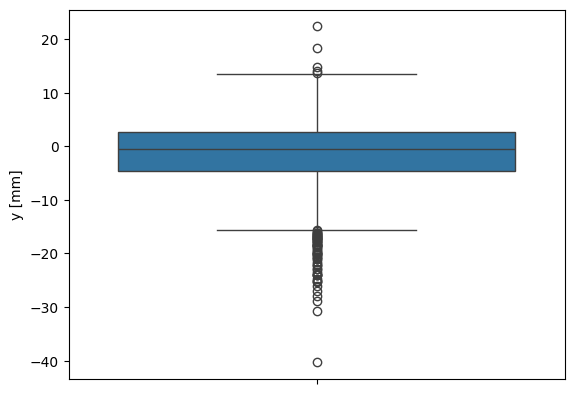

In [ ]:
plt.clf()
sb.boxplot(merged_data_real['y [mm]'])
plt.show()

Shapiro-Wilk Test für die X-Koordinaten der Treffer

In [ ]:
print("Shapiro-Wilk Test for x-values: ", stats.shapiro(merged_data_real.iloc[:,4]))

Shapiro-Wilk Test for x-values:  ShapiroResult(statistic=0.9355494976043701, pvalue=5.362480494394721e-29)


Shapiro-Wilk Test für die Y-Koordinaten der Treffer

In [ ]:
print("Shapiro-Wilk Test for y-values: ", stats.shapiro(merged_data_real.iloc[:,5]))

Shapiro-Wilk Test for y-values:  ShapiroResult(statistic=0.952556848526001, pvalue=2.4777965726001265e-25)


Levene-Test für x-y-Wert-Varianzen

In [ ]:
print("Levene Test for x-y-value variances: ", stats.levene(merged_data_real.iloc[:,4], merged_data_real.iloc[:,5]))

Levene Test for x-y-value variances:  LeveneResult(statistic=31.42400384348627, pvalue=2.209618935326234e-08)


Schiefe und Kurtosis

In [ ]:
print("Schiefe und Kurtosis Rohdaten")
print("Schiefe x VR: ", stats.skew(merged_data_vr["x [mm]"]))
print("Kurtosis x VR: ", stats.kurtosis(merged_data_vr["x [mm]"]))
print("Schiefe y VR: ", stats.skew(merged_data_vr["y [mm]"]))
print("Kurtosis y VR: ", stats.kurtosis(merged_data_vr["y [mm]"]), "\n")

print("Schiefe x real: ", stats.skew(merged_data_real["x [mm]"]))
print("Kurtosis x real: ", stats.kurtosis(merged_data_real["x [mm]"]))
print("Schiefe y real: ", stats.skew(merged_data_real["y [mm]"]))
print("Kurtosis y real: ", stats.kurtosis(merged_data_real["y [mm]"]), "\n")

print("Ganzer Datensatz:")
print("Schiefe x: ", stats.skew(merged_data["x [mm]"]))
print("Kurtosis x: ", stats.kurtosis(merged_data["x [mm]"]))
print("Schiefe y: ", stats.skew(merged_data["y [mm]"]))
print("Kurtosis y: ", stats.kurtosis(merged_data["y [mm]"]), "\n")

Schiefe und Kurtosis Rohdaten
Schiefe x VR:  0.2871842987428054
Kurtosis x VR:  17.74747419156596
Schiefe y VR:  -1.1713286724356775
Kurtosis y VR:  3.545567840795033 

Schiefe x real:  0.6662100749973666
Kurtosis x real:  11.914239916945393
Schiefe y real:  -0.958076052665181
Kurtosis y real:  2.1043464283086495 

Ganzer Datensatz:
Schiefe x:  0.39748141374663104
Kurtosis x:  23.850808405554393
Schiefe y:  -1.5791948846116068
Kurtosis y:  6.130437131544321 



-> Schiefe ist einigermaßen ok, Kurtosis ist jedoch zum Teil viel zu hoch!


**4. Versuche zur Herstellung einer Normalverteilung und Varianzgleichheit**

Hilfsfunktionen definieren

In [ ]:
def remove_outliers(col, two_sd=False, based_on_z_values=True):
    if based_on_z_values:
      z = np.abs(stats.zscore(col))
      idx_outliers = (np.where(z>3, True, False) if two_sd==False else np.where(z>2, True, False))
      return pd.Series(idx_outliers, index=col.index)
    else:
    # Wir entfernen Ausreißer auf Basis der Entfernung:
      idx_outliers = np.where(np.abs(col)>70, True, False)
      return pd.Series(idx_outliers, index=col.index)


def plot_data(data, histplot=True, distance=False):
    plt.close()
    fig, axs = plt.subplots(2, 2)
    if distance:
      labels = ["Rohe Distanzwerte VR", "Bearbeitete Distanzwerte VR", "Rohe Distanzwerte Real", "Bearbeitete Distanzwerte Real"]
    else:
      labels = ["Rohe x-Werte", "Bearbeitete x-Werte", "Rohe y-Werte", "Bearbeitete y-Werte"]


    if histplot:
      sb.histplot(data[0], ax=axs[0, 0])
      axs[0, 0].title.set_text(labels[0])

      sb.histplot(data[1], ax=axs[0, 1])
      axs[0, 1].title.set_text(labels[1])

      sb.histplot(data[2], ax=axs[1, 0])
      axs[1, 0].title.set_text(labels[2])

      sb.histplot(data[3], ax=axs[1, 1])
      axs[1, 1].title.set_text(labels[3])
    else:
      sm.qqplot(data[0], ax=axs[0, 0], line ='s')
      axs[0, 0].title.set_text(labels[0])

      sm.qqplot(data[1], ax=axs[0, 1], line ='s')
      axs[0, 1].title.set_text(labels[1])

      sm.qqplot(data[2], ax=axs[1, 0], line ='s')
      axs[1, 0].title.set_text(labels[2])

      sm.qqplot(data[3], ax=axs[1, 1], line ='s')
      axs[1, 1].title.set_text(labels[3])

    plt.tight_layout()
    plt.show()
    print("\n")

Ausreißer entfernen

In [ ]:
out_real_x = remove_outliers(merged_data_real['x [mm]'])
out_real_y = remove_outliers(merged_data_real['y [mm]'])
out_vr_x = remove_outliers(merged_data_vr['x [mm]'])
out_vr_y = remove_outliers(merged_data_vr['y [mm]'])


filtered_real_x = merged_data_real['x [mm]'].where(out_real_x == False).dropna()
filtered_real_y = merged_data_real['y [mm]'].where(out_real_y == False).dropna()
filtered_vr_x = merged_data_vr['x [mm]'].where(out_vr_x == False).dropna()
filtered_vr_y = merged_data_vr['y [mm]'].where(out_vr_y == False).dropna()

print("Anzahl Ausreißer VR x:", merged_data_vr["x [mm]"].count() - filtered_vr_x.count())
print("Anzahl Ausreißer VR y:", merged_data_vr["y [mm]"].count() - filtered_vr_y.count())
print("Anzahl Ausreißer Real x:", merged_data_real["x [mm]"].count() - filtered_real_x.count())
print("Anzahl Ausreißer Real y:", merged_data_real["y [mm]"].count() - filtered_real_y.count())

Anzahl Ausreißer VR x: 31
Anzahl Ausreißer VR y: 34
Anzahl Ausreißer Real x: 18
Anzahl Ausreißer Real y: 27


VR:


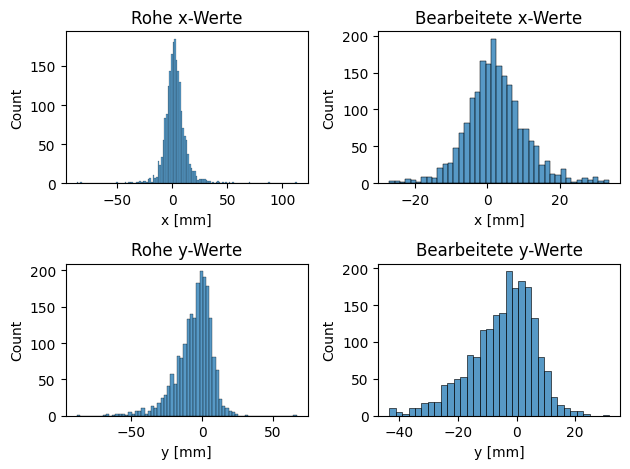

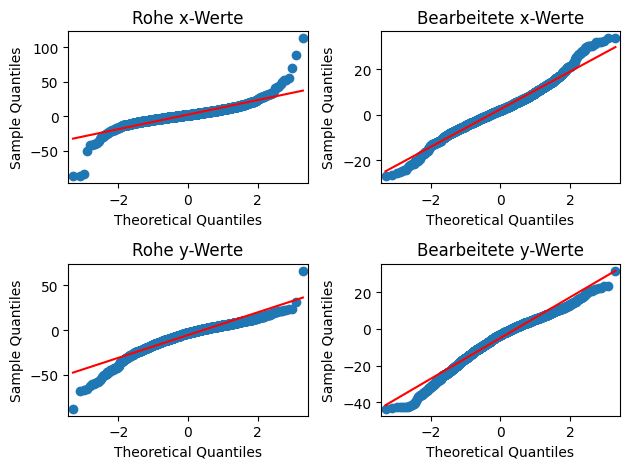



Real:


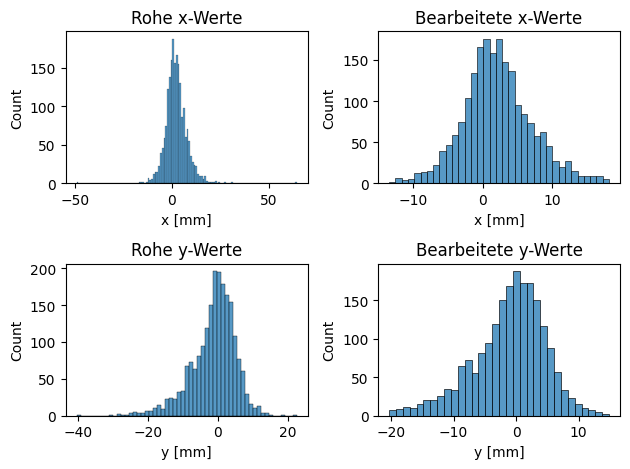

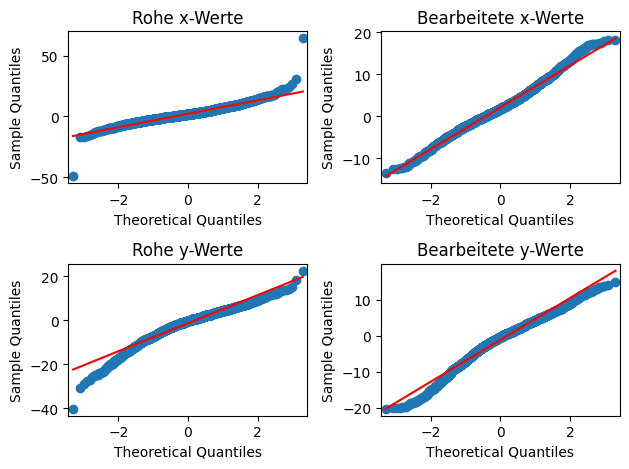

In [ ]:
print("VR:")
plot_data([merged_data_vr["x [mm]"], filtered_vr_x,
           merged_data_vr["y [mm]"], filtered_vr_y])

plot_data([merged_data_vr["x [mm]"], filtered_vr_x,
           merged_data_vr["y [mm]"], filtered_vr_y], histplot=False)

print("Real:")
plot_data([merged_data_real["x [mm]"], filtered_real_x,
           merged_data_real["y [mm]"], filtered_real_y])

plot_data([merged_data_real["x [mm]"], filtered_real_x,
           merged_data_real["y [mm]"], filtered_real_y], histplot=False)

In [ ]:
print("Shapiro-Test VR x ohne Ausreißer: ", stats.shapiro(filtered_vr_x))
print("Shapiro-Test VR y ohne Ausreißer: ", stats.shapiro(filtered_vr_y))
print("Levene-Test VR x-y ohne Ausreißer: ", stats.levene(filtered_vr_x, filtered_vr_y), "\n")

print("Shapiro-Test Real x ohne Ausreißer: ", stats.shapiro(filtered_real_x))
print("Shapiro-Test Real y ohne Ausreißer: ", stats.shapiro(filtered_real_y))
print("Levene-Test Real x-y ohne Ausreißer: ", stats.levene(filtered_real_x, filtered_real_y), "\n")

print("Schiefe und Kurtosis Ausreißer herausgefiltert")
print("Schiefe x VR: ", stats.skew(filtered_vr_x))
print("Kurtosis x VR: ", stats.kurtosis(filtered_vr_x))
print("Schiefe y VR: ", stats.skew(filtered_vr_y))
print("Kurtosis y VR: ", stats.kurtosis(filtered_vr_y), "\n")

print("Schiefe x real: ", stats.skew(filtered_real_x))
print("Kurtosis x real: ", stats.kurtosis(filtered_real_x))
print("Schiefe y real: ", stats.skew(filtered_real_y))
print("Kurtosis y real: ", stats.kurtosis(filtered_real_y), "\n")

Shapiro-Test VR x ohne Ausreißer:  ShapiroResult(statistic=0.9815812706947327, pvalue=1.7447917331043453e-15)
Shapiro-Test VR y ohne Ausreißer:  ShapiroResult(statistic=0.971394419670105, pvalue=1.2545773387348758e-19)
Levene-Test VR x-y ohne Ausreißer:  LeveneResult(statistic=144.69492101089696, pvalue=9.041908265650501e-33) 

Shapiro-Test Real x ohne Ausreißer:  ShapiroResult(statistic=0.9907422661781311, pvalue=3.869337628081837e-10)
Shapiro-Test Real y ohne Ausreißer:  ShapiroResult(statistic=0.9753358960151672, pvalue=2.9833306903393697e-18)
Levene-Test Real x-y ohne Ausreißer:  LeveneResult(statistic=34.444040432663535, pvalue=4.735596320884236e-09) 

Schiefe und Kurtosis Ausreißer herausgefiltert
Schiefe x VR:  0.28386474935418704
Kurtosis x VR:  1.3665462347188324
Schiefe y VR:  -0.6646475715880543
Kurtosis y VR:  0.5593929224645815 

Schiefe x real:  0.26852079024634995
Kurtosis x real:  0.48651187612991453
Schiefe y real:  -0.6022014920901091
Kurtosis y real:  0.4745303106702

Distanz anschauen:

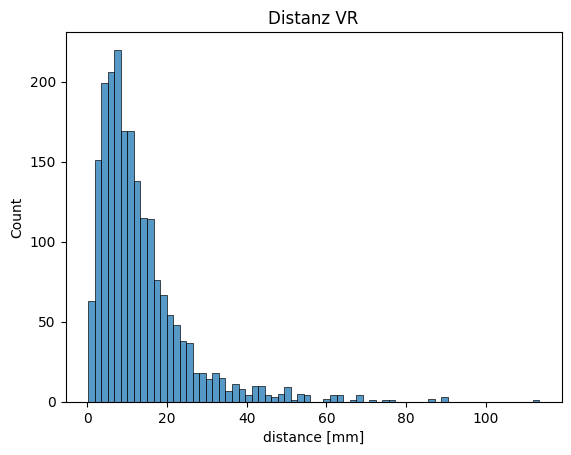

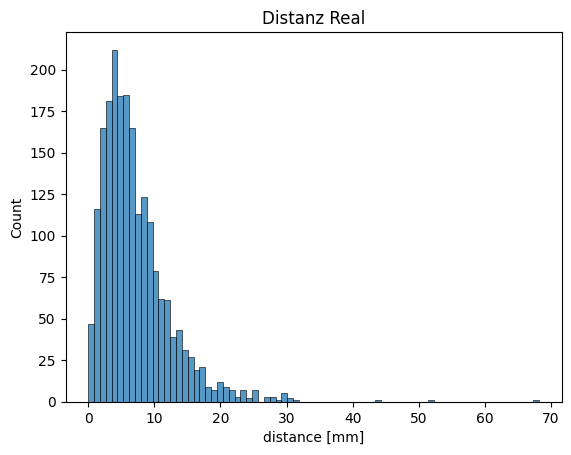

In [ ]:
plt.clf()
sb.histplot(merged_data_vr, x = "distance [mm]")
plt.title("Distanz VR")
plt.show()

plt.clf()

sb.histplot(data=merged_data_real, x= "distance [mm]")
plt.title("Distanz Real")
plt.show()

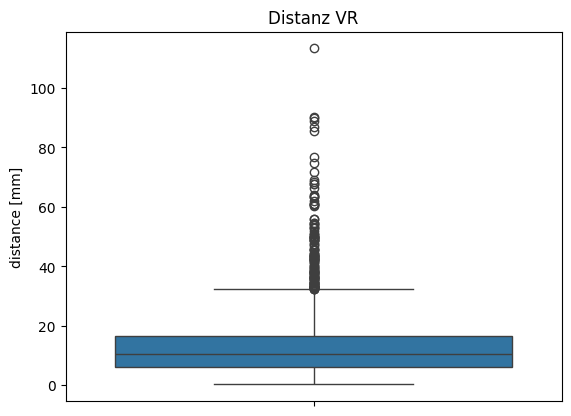

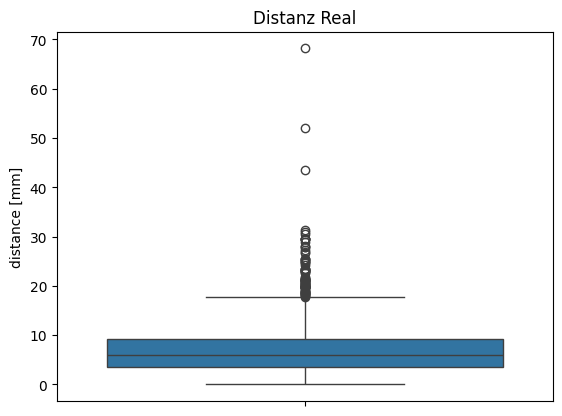

In [ ]:
plt.clf()
sb.boxplot(merged_data_vr["distance [mm]"])
plt.title("Distanz VR")
plt.show()

plt.clf()

sb.boxplot(data=merged_data_real["distance [mm]"])
plt.title("Distanz Real")
plt.show()

Anzahl Ausreißer VR:  48
Anzahl Ausreißer Real:  35 



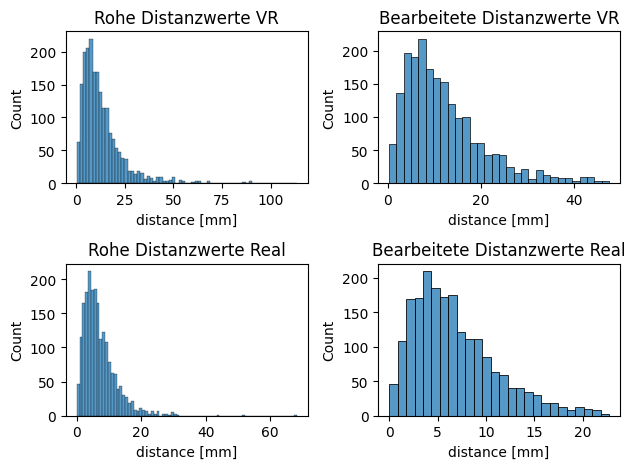



VR: 


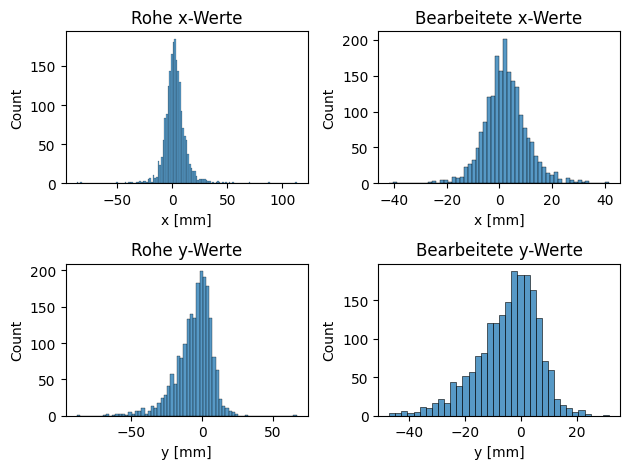

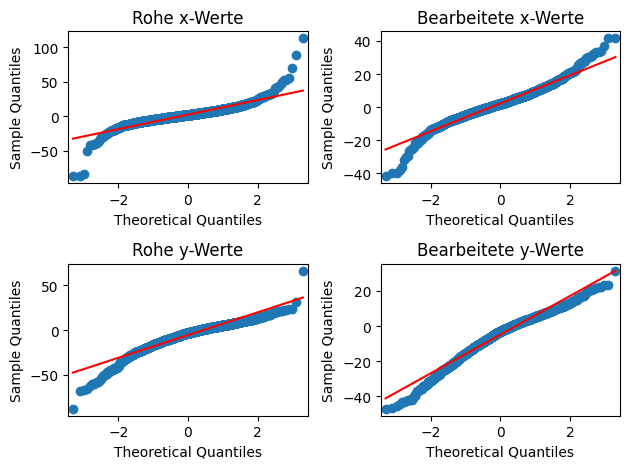



Real: 


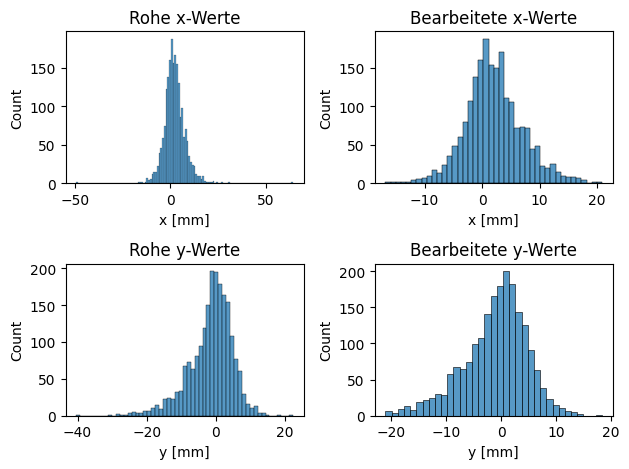

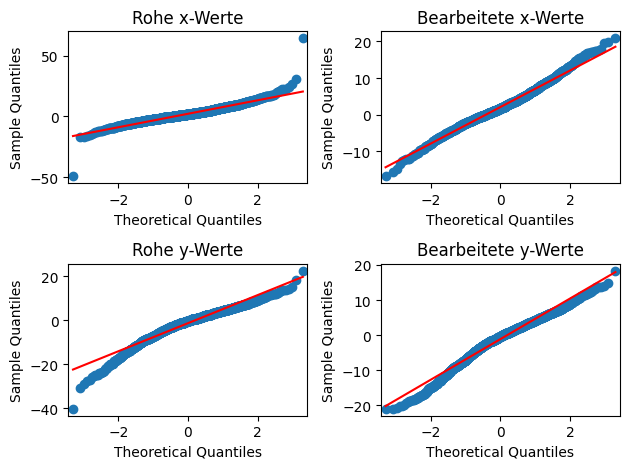

In [ ]:
out_vr_distance = remove_outliers(merged_data_vr["distance [mm]"])
out_real_distance = remove_outliers(merged_data_real["distance [mm]"])

filtered_vr_distance = merged_data_vr["distance [mm]"].where(out_vr_distance == False).dropna()
filtered_real_distance = merged_data_real["distance [mm]"].where(out_real_distance == False).dropna()

print("Anzahl Ausreißer VR: ", merged_data_vr["distance [mm]"].count() - filtered_vr_distance.count())
print("Anzahl Ausreißer Real: ", merged_data_real["distance [mm]"].count() - filtered_real_distance.count(), "\n")

plot_data([merged_data_vr["distance [mm]"], filtered_vr_distance,
           merged_data_real["distance [mm]"], filtered_real_distance], distance=True)

filtered_vr = merged_data_vr.where(out_vr_distance == False).dropna()
filtered_real = merged_data_real.where(out_real_distance == False).dropna()

print("VR: ")
plot_data([merged_data_vr["x [mm]"], filtered_vr["x [mm]"],
           merged_data_vr["y [mm]"], filtered_vr["y [mm]"]])

plot_data([merged_data_vr["x [mm]"], filtered_vr["x [mm]"],
           merged_data_vr["y [mm]"], filtered_vr["y [mm]"]], histplot=False)

print("Real: ")
plot_data([merged_data_real["x [mm]"], filtered_real["x [mm]"],
           merged_data_real["y [mm]"], filtered_real["y [mm]"]])

plot_data([merged_data_real["x [mm]"], filtered_real["x [mm]"],
           merged_data_real["y [mm]"], filtered_real["y [mm]"]], histplot=False)

In [ ]:
print("Shapiro-Test VR x ohne Distanz-Ausreißer: ", stats.shapiro(filtered_vr["x [mm]"]))
print("Shapiro-Test VR y ohne Distanz-Ausreißer: ", stats.shapiro(filtered_vr["y [mm]"]))
print("Levene-Test VR x-y ohne Distanz-Ausreißer: ", stats.levene(filtered_vr["x [mm]"], filtered_vr["y [mm]"]), "\n")

print("Shapiro-Test Real x ohne Distanz-Ausreißer: ", stats.shapiro(filtered_real["x [mm]"]))
print("Shapiro-Test Real y ohne Distanz-Ausreißer: ", stats.shapiro(filtered_real["y [mm]"]))
print("Levene-Test Real x-y ohne Distanz-Ausreißer: ", stats.levene(filtered_real["x [mm]"], filtered_real["y [mm]"]), "\n")

print("Schiefe und Kurtosis Distanz-Ausreißer herausgefiltert")
print("Schiefe x VR: ", stats.skew(filtered_vr["x [mm]"]))
print("Kurtosis x VR: ", stats.kurtosis(filtered_vr["x [mm]"]))
print("Schiefe y VR: ", stats.skew(filtered_vr["y [mm]"]))
print("Kurtosis y VR: ", stats.kurtosis(filtered_vr["y [mm]"]), "\n")

print("Schiefe x real: ", stats.skew(filtered_real["x [mm]"]))
print("Kurtosis x real: ", stats.kurtosis(filtered_real["x [mm]"]))
print("Schiefe y real: ", stats.skew(filtered_real["y [mm]"]))
print("Kurtosis y real: ", stats.kurtosis(filtered_real["y [mm]"]), "\n")

Shapiro-Test VR x ohne Distanz-Ausreißer:  ShapiroResult(statistic=0.9687946438789368, pvalue=1.9411020919778553e-20)
Shapiro-Test VR y ohne Distanz-Ausreißer:  ShapiroResult(statistic=0.9712129831314087, pvalue=1.2812256084031252e-19)
Levene-Test VR x-y ohne Distanz-Ausreißer:  LeveneResult(statistic=127.92893828004577, pvalue=3.2125156199654864e-29) 

Shapiro-Test Real x ohne Distanz-Ausreißer:  ShapiroResult(statistic=0.9905272722244263, pvalue=3.0579008769571203e-10)
Shapiro-Test Real y ohne Distanz-Ausreißer:  ShapiroResult(statistic=0.9766519665718079, pvalue=1.0947617947492339e-17)
Levene-Test Real x-y ohne Distanz-Ausreißer:  LeveneResult(statistic=32.61067791760875, pvalue=1.2066451830630264e-08) 

Schiefe und Kurtosis Distanz-Ausreißer herausgefiltert
Schiefe x VR:  0.013764855930564725
Kurtosis x VR:  2.778738020526627
Schiefe y VR:  -0.6833070861254941
Kurtosis y VR:  0.668704994768389 

Schiefe x real:  0.23692235628408118
Kurtosis x real:  0.707920140539914
Schiefe y real

Kompletter Datensatz Ausreißer entfernen auf Basis der Distanz:

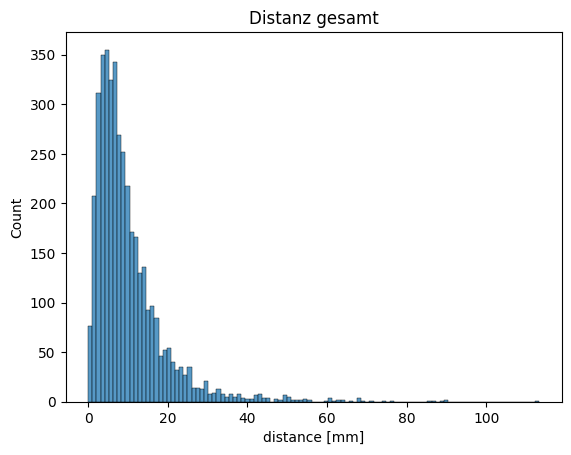

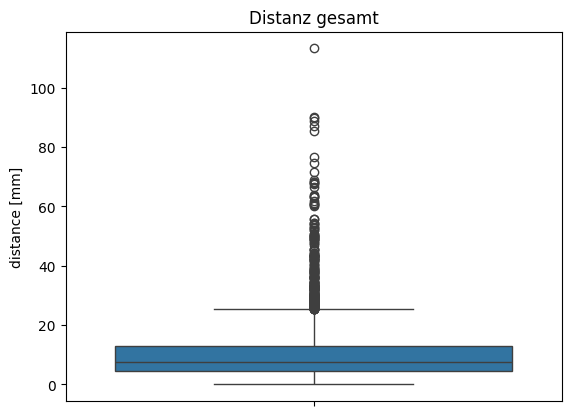



Anzahl Ausreißer gesamt:  85




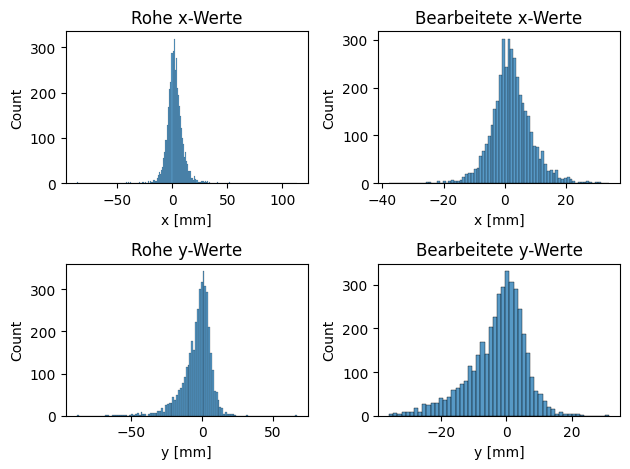

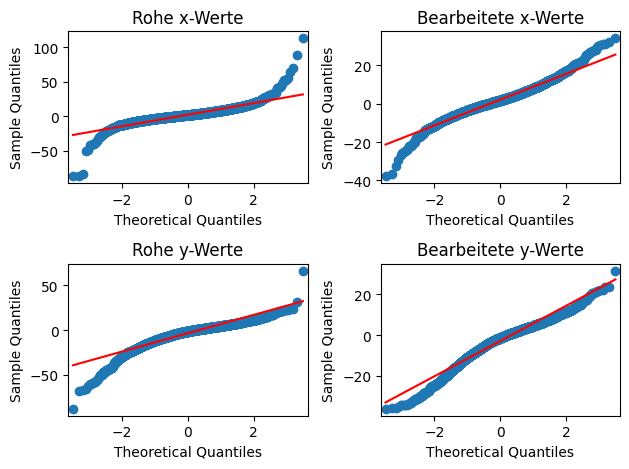

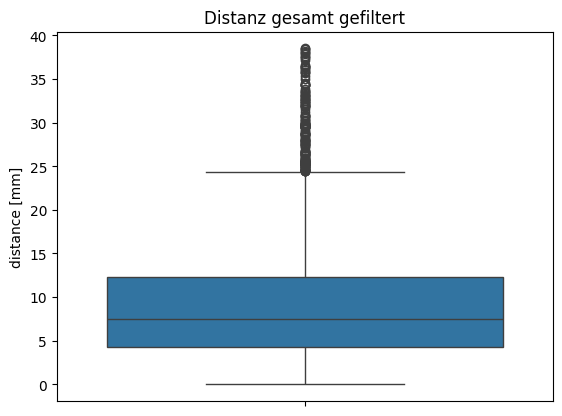

In [ ]:
plt.clf()
sb.histplot(merged_data["distance [mm]"])
plt.title("Distanz gesamt")
plt.show()

print("\n")
plt.clf()

sb.boxplot(data=merged_data["distance [mm]"])
plt.title("Distanz gesamt")
plt.show()

plt.clf()

out_complete_distance = remove_outliers(merged_data["distance [mm]"])
filtered_complete_distance = merged_data.where(out_complete_distance == False).dropna(subset=["x [mm]", "y [mm]"])

print("\n")

print("Anzahl Ausreißer gesamt: ", merged_data["x [mm]"].count() - filtered_complete_distance["x [mm]"].count())

print("\n")

filtered_vr = merged_data_vr.where(out_vr_distance == False).dropna()
filtered_real = merged_data_real.where(out_real_distance == False).dropna()

plot_data([merged_data["x [mm]"], filtered_complete_distance["x [mm]"],
           merged_data["y [mm]"], filtered_complete_distance["y [mm]"]])

plot_data([merged_data["x [mm]"], filtered_complete_distance["x [mm]"],
           merged_data["y [mm]"], filtered_complete_distance["y [mm]"]], histplot=False)

print("\n")

sb.boxplot(data=filtered_complete_distance["distance [mm]"])
plt.title("Distanz gesamt gefiltert")
plt.show()

In [ ]:
print("Shapiro-Test x ohne Distanz-Ausreißer: ", stats.shapiro(filtered_complete_distance["x [mm]"]))
print("Shapiro-Test y ohne Distanz-Ausreißer: ", stats.shapiro(filtered_complete_distance["y [mm]"]))
print("Levene-Test x-y ohne Distanz-Ausreißer: ", stats.levene(filtered_complete_distance["x [mm]"], filtered_complete_distance["y [mm]"]), "\n")

print("Schiefe und Kurtosis Distanz-Ausreißer herausgefiltert")
print("Schiefe x: ", stats.skew(filtered_complete_distance["x [mm]"]))
print("Kurtosis x: ", stats.kurtosis(filtered_complete_distance["x [mm]"]))
print("Schiefe y: ", stats.skew(filtered_complete_distance["y [mm]"]))
print("Kurtosis y: ", stats.kurtosis(filtered_complete_distance["y [mm]"]), "\n")

Shapiro-Test x ohne Distanz-Ausreißer:  ShapiroResult(statistic=0.9737190008163452, pvalue=1.2946270568006105e-26)
Shapiro-Test y ohne Distanz-Ausreißer:  ShapiroResult(statistic=0.9575960636138916, pvalue=9.570135912321985e-33)
Levene-Test x-y ohne Distanz-Ausreißer:  LeveneResult(statistic=166.24822959681546, pvalue=1.1495100672612095e-37) 

Schiefe und Kurtosis Distanz-Ausreißer herausgefiltert
Schiefe x:  0.10495785169109902
Kurtosis x:  2.4145429456753433
Schiefe y:  -0.7988735628235254
Kurtosis y:  1.0891463535892916 



Transformationen

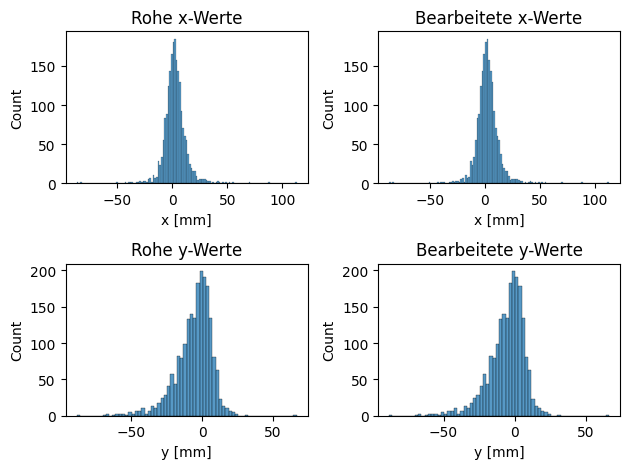

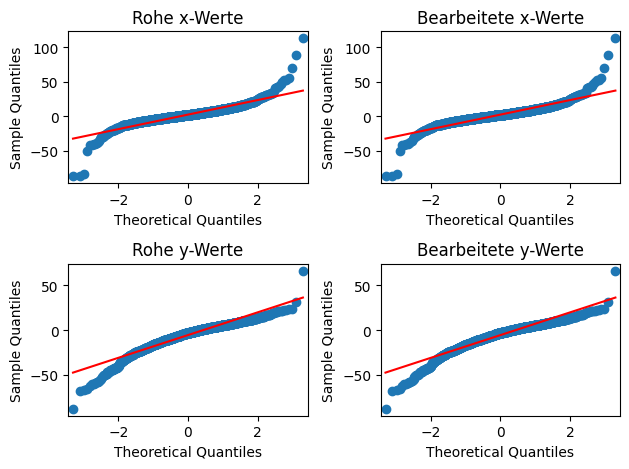

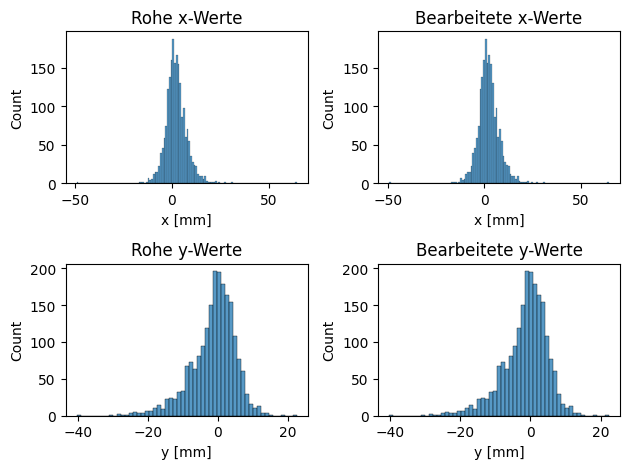

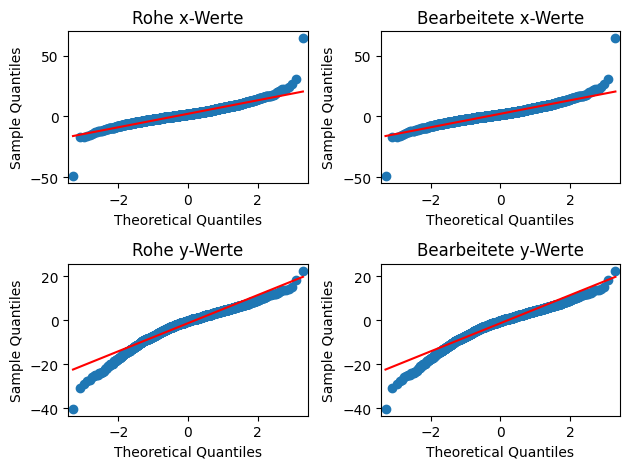

In [ ]:
def transformation(x):
    try:
      # Logarithmieren
      #return (np.log(abs(x)) if x != 0 else np.log(abs(x+0.0000000001)))

      # Wurzel ziehen
      #return np.sqrt(abs(x))

      # Kehrwert
      #return 1/x

      # Funktioniert alles nicht:
      return x

    except ZeroDivisionError:
      return 0

    # Theoretisch würde es auch "Power Transformer" oder generell ML-Methoden geben, um die Daten in eine Normalverteilung zu überführen

trans_vr_x = merged_data_vr["x [mm]"].apply(transformation)
trans_vr_y = merged_data_vr["y [mm]"].apply(transformation)

trans_real_x = merged_data_real["x [mm]"].apply(transformation)
trans_real_y = merged_data_real["y [mm]"].apply(transformation)

# VR
plot_data([merged_data_vr["x [mm]"], trans_vr_x,
           merged_data_vr["y [mm]"], trans_vr_y])

plot_data([merged_data_vr["x [mm]"], trans_vr_x,
           merged_data_vr["y [mm]"], trans_vr_y], histplot=False)

# Real
plot_data([merged_data_real["x [mm]"], trans_real_x,
           merged_data_real["y [mm]"], trans_real_y])

plot_data([merged_data_real["x [mm]"], trans_real_x,
           merged_data_real["y [mm]"], trans_real_y], histplot=False)


Tests

In [ ]:
print("Shapiro-Test VR x transformiert: ", stats.shapiro(trans_vr_x))
print("Shapiro-Test VR y transformiert: ", stats.shapiro(trans_vr_y))
print("Levene-Test VR transformiert: ", stats.levene(trans_vr_x, trans_vr_y), "\n")

print("Shapiro-Test Real x transformiert: ", stats.shapiro(trans_real_x))
print("Shapiro-Test Real y transformiert: ", stats.shapiro(trans_real_y))
print("Levene-Test Real transformiert: ", stats.levene(trans_real_x, trans_real_y), "\n")

print("Schiefe x VR: ", stats.skew(trans_vr_x))
print("Kurtosis x VR: ", stats.kurtosis(trans_vr_x))
print("Schiefe y VR: ", stats.skew(trans_vr_y))
print("Kurtosis y VR: ", stats.kurtosis(trans_vr_y), "\n")

print("Schiefe und Kurtosis transformiert")
print("Schiefe x real: ", stats.skew(trans_real_x))
print("Kurtosis x real: ", stats.kurtosis(trans_real_x))
print("Schiefe y real: ", stats.skew(trans_real_y))
print("Kurtosis y real: ", stats.kurtosis(trans_real_y), "\n")

Shapiro-Test VR x transformiert:  ShapiroResult(statistic=0.8579486608505249, pvalue=1.387492871854289e-39)
Shapiro-Test VR y transformiert:  ShapiroResult(statistic=0.9271930456161499, pvalue=1.8384633845730588e-30)
Levene-Test VR transformiert:  LeveneResult(statistic=86.41388778795417, pvalue=2.3101623941309193e-20) 

Shapiro-Test Real x transformiert:  ShapiroResult(statistic=0.9355494976043701, pvalue=5.362480494394721e-29)
Shapiro-Test Real y transformiert:  ShapiroResult(statistic=0.952556848526001, pvalue=2.4777965726001265e-25)
Levene-Test Real transformiert:  LeveneResult(statistic=31.42400384348627, pvalue=2.209618935326234e-08) 

Schiefe x VR:  0.2871842987428054
Kurtosis x VR:  17.74747419156596
Schiefe y VR:  -1.1713286724356775
Kurtosis y VR:  3.545567840795033 

Schiefe und Kurtosis transformiert
Schiefe x real:  0.6662100749973666
Kurtosis x real:  11.914239916945393
Schiefe y real:  -0.958076052665181
Kurtosis y real:  2.1043464283086495 



Tests für Daten der Mittelwerte

Schiefe x:  1.4305343565044435
Kurtosis x:  11.800672781416766 

Schiefe y:  -2.1411151252687066
Kurtosis y:  7.215624915182042 

Shapiro-Test x:  ShapiroResult(statistic=0.866662859916687, pvalue=2.1097490799266716e-25)
Shapiro-Test y:  ShapiroResult(statistic=0.8296350836753845, pvalue=3.3136544324730838e-28)
Levene-Test x-y:  LeveneResult(statistic=50.80883169521212, pvalue=1.5419954897471134e-12) 



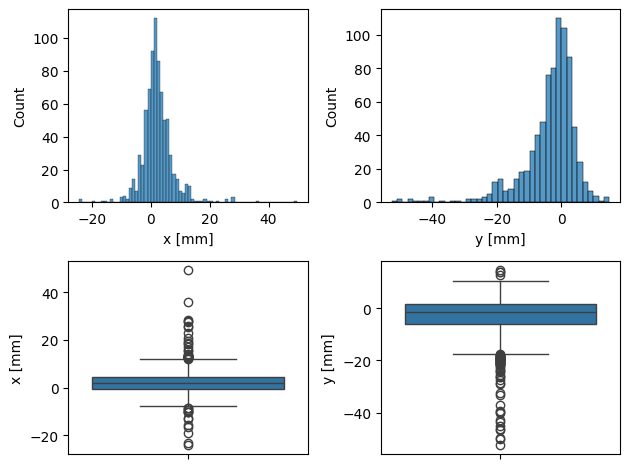

In [ ]:
merged_data_means = merged_data.groupby(["Participant", "mode", "position", "series"], as_index=False).mean(numeric_only=True)

print("Schiefe x: ", stats.skew(merged_data_means["x [mm]"]))
print("Kurtosis x: ", stats.kurtosis(merged_data_means["x [mm]"]), "\n")

print("Schiefe y: ", stats.skew(merged_data_means["y [mm]"]))
print("Kurtosis y: ", stats.kurtosis(merged_data_means["y [mm]"]), "\n")

print("Shapiro-Test x: ", stats.shapiro(merged_data_means["x [mm]"]))
print("Shapiro-Test y: ", stats.shapiro(merged_data_means["y [mm]"]))
print("Levene-Test x-y: ", stats.levene(merged_data_means["x [mm]"], merged_data_means["y [mm]"]), "\n")


fig, axes = plt.subplots(2, 2)
sb.histplot(merged_data_means["x [mm]"], ax=axes[0, 0])
sb.histplot(merged_data_means["y [mm]"], ax=axes[0, 1])

sb.boxplot(merged_data_means["x [mm]"], ax=axes[1, 0])
sb.boxplot(merged_data_means["y [mm]"], ax=axes[1, 1])

plt.tight_layout()
plt.show()

Nur Mittelwerte der VP:

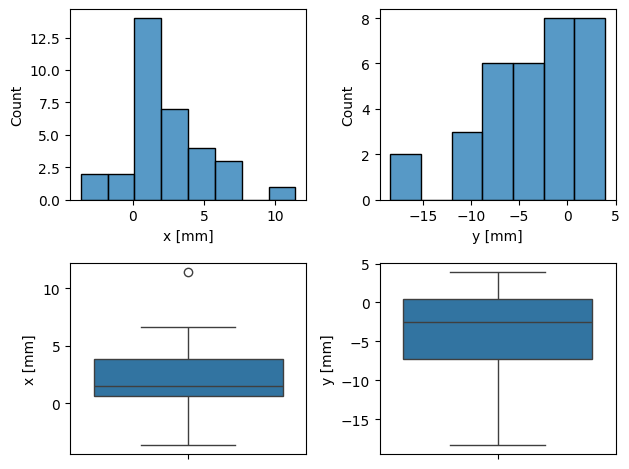



Schiefe x:  0.8979538921035156
Kurtosis x:  1.8627554735040333 

Schiefe y:  -0.967743058962428
Kurtosis y:  0.6067235485113907 

Shapiro-Test x:  ShapiroResult(statistic=0.9345249533653259, pvalue=0.04716436564922333)
Shapiro-Test y:  ShapiroResult(statistic=0.9090474843978882, pvalue=0.009221591055393219)
Levene-Test x-y:  LeveneResult(statistic=10.402086291367093, pvalue=0.001983872288282259) 

Ausreißer herausgefiltert:


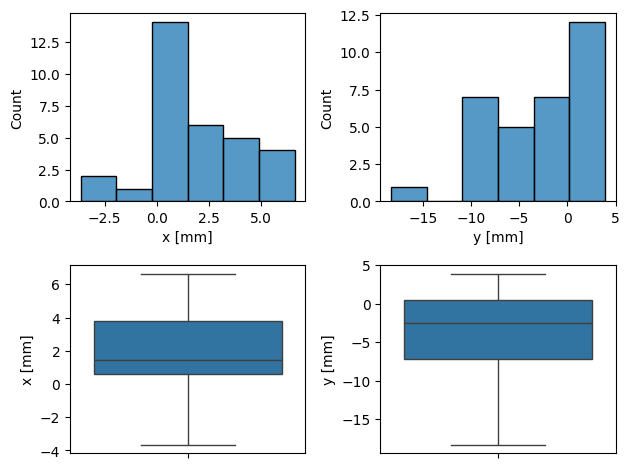



Schiefe x:  0.08712736047340505
Kurtosis x:  0.044563015809944595 

Schiefe y:  -0.8459641428930658
Kurtosis y:  0.5938549629171366 

Shapiro-Test x:  ShapiroResult(statistic=0.9652307629585266, pvalue=0.3791208863258362)
Shapiro-Test y:  ShapiroResult(statistic=0.928633987903595, pvalue=0.03588225692510605)
Levene-Test x-y:  LeveneResult(statistic=13.683101809943803, pvalue=0.0004611812871180008) 



' VP 6 zusätzlich entfernt (y-Ausreißer)\ntest = filtered_participants_distance.loc[filtered_participants_distance["Participant"] != 6]\n\nprint("Schiefe x: ", stats.skew(test["x [mm]"]))\nprint("Kurtosis x: ", stats.kurtosis(test["x [mm]"]), "\n")\n\nprint("Schiefe y: ", stats.skew(test["y [mm]"]))\nprint("Kurtosis y: ", stats.kurtosis(test["y [mm]"]), "\n")\n\nprint("Shapiro-Test x: ", stats.shapiro(test["x [mm]"]))\nprint("Shapiro-Test y: ", stats.shapiro(test["y [mm]"]))\nprint("Levene-Test x-y: ", stats.levene(test["x [mm]"], test["y [mm]"]), "\n")\n\nfig, axes = plt.subplots(2, 2)\nsb.histplot(test["x [mm]"], ax=axes[0, 0])\nsb.histplot(test["y [mm]"], ax=axes[0, 1])\n\nsb.boxplot(test["x [mm]"], ax=axes[1, 0])\nsb.boxplot(test["y [mm]"], ax=axes[1, 1])\n\nplt.tight_layout()\nplt.show()\nprint("\n")\n'

In [ ]:
merged_data_only_participants = merged_data.groupby(["Participant"], as_index=False).mean(numeric_only=True)

fig, axes = plt.subplots(2, 2)
sb.histplot(merged_data_only_participants["x [mm]"], ax=axes[0, 0])
sb.histplot(merged_data_only_participants["y [mm]"], ax=axes[0, 1])

sb.boxplot(merged_data_only_participants["x [mm]"], ax=axes[1, 0])
sb.boxplot(merged_data_only_participants["y [mm]"], ax=axes[1, 1])

plt.tight_layout()
plt.show()
print("\n")

print("Schiefe x: ", stats.skew(merged_data_only_participants["x [mm]"]))
print("Kurtosis x: ", stats.kurtosis(merged_data_only_participants["x [mm]"]), "\n")

print("Schiefe y: ", stats.skew(merged_data_only_participants["y [mm]"]))
print("Kurtosis y: ", stats.kurtosis(merged_data_only_participants["y [mm]"]), "\n")

print("Shapiro-Test x: ", stats.shapiro(merged_data_only_participants["x [mm]"]))
print("Shapiro-Test y: ", stats.shapiro(merged_data_only_participants["y [mm]"]))
print("Levene-Test x-y: ", stats.levene(merged_data_only_participants["x [mm]"], merged_data_only_participants["y [mm]"]), "\n")


print("Ausreißer herausgefiltert:")

out_participants_distance = remove_outliers(merged_data_only_participants["distance [mm]"])
filtered_participants_distance = merged_data_only_participants.where(out_participants_distance == False).dropna(subset=["x [mm]", "y [mm]"])

fig, axes = plt.subplots(2, 2)
sb.histplot(filtered_participants_distance["x [mm]"], ax=axes[0, 0])
sb.histplot(filtered_participants_distance["y [mm]"], ax=axes[0, 1])

sb.boxplot(filtered_participants_distance["x [mm]"], ax=axes[1, 0])
sb.boxplot(filtered_participants_distance["y [mm]"], ax=axes[1, 1])

plt.tight_layout()
plt.show()
print("\n")

print("Schiefe x: ", stats.skew(filtered_participants_distance["x [mm]"]))
print("Kurtosis x: ", stats.kurtosis(filtered_participants_distance["x [mm]"]), "\n")

print("Schiefe y: ", stats.skew(filtered_participants_distance["y [mm]"]))
print("Kurtosis y: ", stats.kurtosis(filtered_participants_distance["y [mm]"]), "\n")

print("Shapiro-Test x: ", stats.shapiro(filtered_participants_distance["x [mm]"]))
print("Shapiro-Test y: ", stats.shapiro(filtered_participants_distance["y [mm]"]))
print("Levene-Test x-y: ", stats.levene(filtered_participants_distance["x [mm]"], filtered_participants_distance["y [mm]"]), "\n")

''' VP 6 zusätzlich entfernt (y-Ausreißer)
test = filtered_participants_distance.loc[filtered_participants_distance["Participant"] != 6]

print("Schiefe x: ", stats.skew(test["x [mm]"]))
print("Kurtosis x: ", stats.kurtosis(test["x [mm]"]), "\n")

print("Schiefe y: ", stats.skew(test["y [mm]"]))
print("Kurtosis y: ", stats.kurtosis(test["y [mm]"]), "\n")

print("Shapiro-Test x: ", stats.shapiro(test["x [mm]"]))
print("Shapiro-Test y: ", stats.shapiro(test["y [mm]"]))
print("Levene-Test x-y: ", stats.levene(test["x [mm]"], test["y [mm]"]), "\n")

fig, axes = plt.subplots(2, 2)
sb.histplot(test["x [mm]"], ax=axes[0, 0])
sb.histplot(test["y [mm]"], ax=axes[0, 1])

sb.boxplot(test["x [mm]"], ax=axes[1, 0])
sb.boxplot(test["y [mm]"], ax=axes[1, 1])

plt.tight_layout()
plt.show()
print("\n")
'''

**Finale, besprochene Transformation**

Wir entfernen Ausreißer, welche außerhalb des äußersten Rings der Zielscheibe liegen (Distanz > 7cm)

Anzahl Ausreißer VR gesamt:  9
Anzahl Ausreißer Real gesamt:  0


VR-Daten gefiltert:


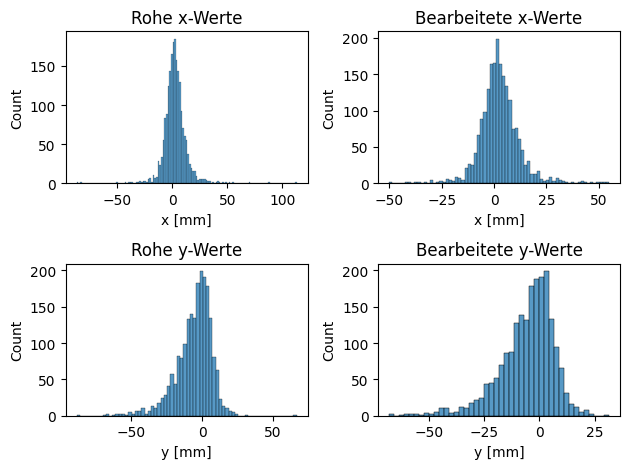

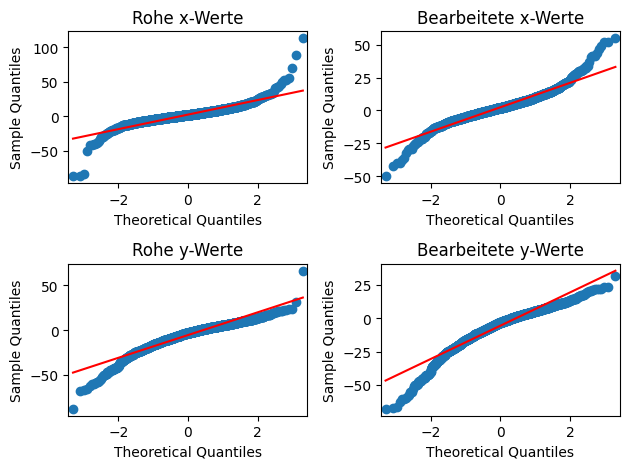

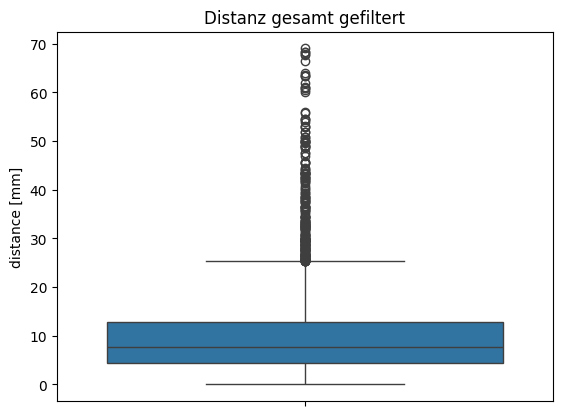



Schiefe x VR: 0.355167121818579
Kurtosis x VR: 4.369946969410723 

Schiefe y VR: -1.183874181939395
Kurtosis y VR: 2.5559835163811595 

Zum Vergleich:
Schiefe x Real: 0.6662100749973666
Kurtosis x Real: 11.914239916945393 

Schiefe y Real: -0.958076052665181
Kurtosis y Real: 2.1043464283086495


Schiefe und Kurtosis Gesamtdatensatz gefiltert
Schiefe x: 0.46902176796318457
Kurtosis x: 7.095140448663033 

Schiefe y: -1.5753776269025335
Kurtosis y: 4.873970685198486


Gesamter Datensatz gefiltert:


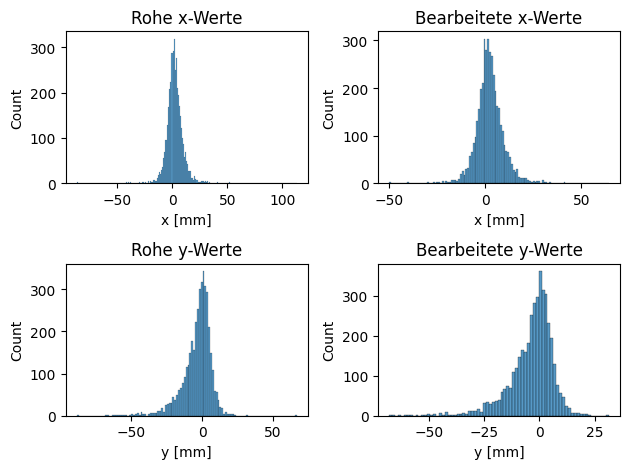

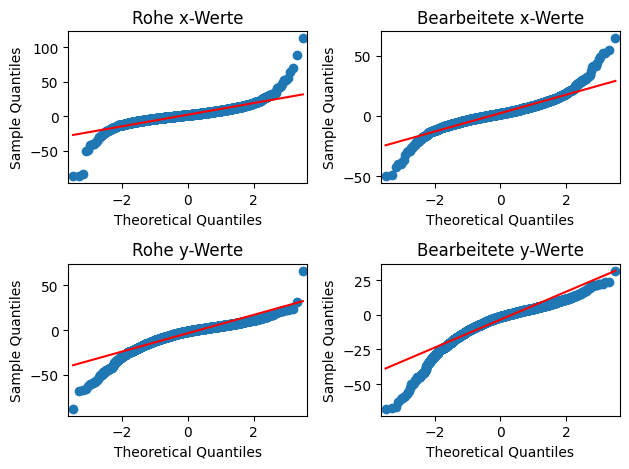





Auf VP heruntergebrochen:


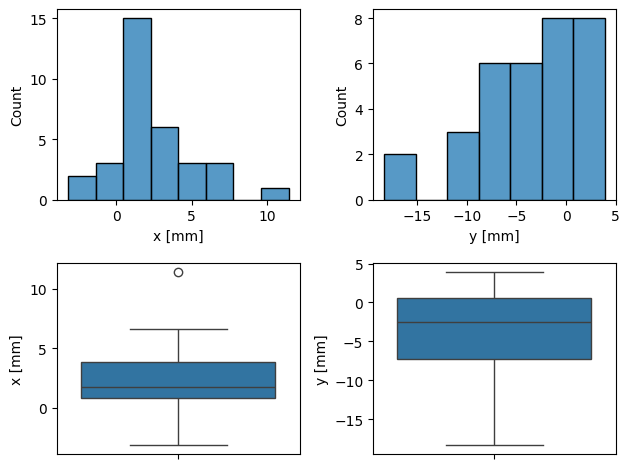



Schiefe x:  1.0408095970793756
Kurtosis x:  2.134280795272163 

Schiefe y:  -0.9277121511621584
Kurtosis y:  0.4913262470291917 

Shapiro-Test x:  ShapiroResult(statistic=0.9255337715148926, pvalue=0.02615153044462204)
Shapiro-Test y:  ShapiroResult(statistic=0.9162182211875916, pvalue=0.014415457844734192)
Levene-Test x-y:  LeveneResult(statistic=11.43676997123987, pvalue=0.0012320884604814723) 

                x [mm]     y [mm]  distance [mm]
Participant                                     
1.0           0.315011  -0.077514       8.465240
2.0           0.636679  -9.402275      13.552044
3.0          -1.760835   1.454246       6.775121
4.0           1.257170   0.443131       6.424712
5.0           2.102389  -5.502562      10.850084
6.0          -3.200571 -17.327509      22.314113
7.0          -0.152433  -3.860158       8.988693
8.0           2.354221   0.519610       8.650278
9.0           0.933771  -0.061161       4.783825
10.0          4.234832  -7.433756      14.358341
11.0     

In [ ]:
out_vr_distance_final = remove_outliers(merged_data_vr["distance [mm]"], based_on_z_values=False)
out_real_distance_final = remove_outliers(merged_data_real["distance [mm]"], based_on_z_values=False)

filtered_vr_distance_final = merged_data_vr.where(out_vr_distance_final == False).dropna(subset=["x [mm]", "y [mm]"])
filtered_real_distance_final = merged_data_real.where(out_real_distance_final == False).dropna(subset=["x [mm]", "y [mm]"])

del filtered_vr_distance_final["hammer"], filtered_vr_distance_final["left/righthanded"]


print("Anzahl Ausreißer VR gesamt: ", merged_data_vr["distance [mm]"].count() - filtered_vr_distance_final["distance [mm]"].count())
print("Anzahl Ausreißer Real gesamt: ", merged_data_real["distance [mm]"].count() - filtered_real_distance_final["distance [mm]"].count())


print("\n")
print("VR-Daten gefiltert:")
plot_data([merged_data_vr["x [mm]"], filtered_vr_distance_final["x [mm]"],
           merged_data_vr["y [mm]"], filtered_vr_distance_final["y [mm]"]])

plot_data([merged_data_vr["x [mm]"], filtered_vr_distance_final["x [mm]"],
           merged_data_vr["y [mm]"], filtered_vr_distance_final["y [mm]"]], histplot=False)

print("\n")

filtered_vr_distance_final["mode"] = "VR"
filtered_real_distance_final["mode"] = "Real"

final_filtered_data = pd.concat([filtered_vr_distance_final, filtered_real_distance_final]).reset_index()

sb.boxplot(data=final_filtered_data["distance [mm]"])
plt.title("Distanz gesamt gefiltert")
plt.show()

print("\n")

print("Schiefe x VR:", stats.skew(filtered_vr_distance_final["x [mm]"]))
print("Kurtosis x VR:", stats.kurtosis(filtered_vr_distance_final["x [mm]"]), "\n")

print("Schiefe y VR:", stats.skew(filtered_vr_distance_final["y [mm]"]))
print("Kurtosis y VR:", stats.kurtosis(filtered_vr_distance_final["y [mm]"]), "\n")

print("Zum Vergleich:")
print("Schiefe x Real:", stats.skew(filtered_real_distance_final["x [mm]"]))
print("Kurtosis x Real:", stats.kurtosis(filtered_real_distance_final["x [mm]"]), "\n")

print("Schiefe y Real:", stats.skew(filtered_real_distance_final["y [mm]"]))
print("Kurtosis y Real:", stats.kurtosis(filtered_real_distance_final["y [mm]"]))
print("\n")

print("Schiefe und Kurtosis Gesamtdatensatz gefiltert")
print("Schiefe x:", stats.skew(final_filtered_data["x [mm]"]))
print("Kurtosis x:", stats.kurtosis(final_filtered_data["x [mm]"]), "\n")

print("Schiefe y:", stats.skew(final_filtered_data["y [mm]"]))
print("Kurtosis y:", stats.kurtosis(final_filtered_data["y [mm]"]))
print("\n")

print("Gesamter Datensatz gefiltert:")
plot_data([merged_data["x [mm]"], final_filtered_data["x [mm]"],
           merged_data["y [mm]"], final_filtered_data["y [mm]"]])

plot_data([merged_data["x [mm]"], final_filtered_data["x [mm]"],
           merged_data["y [mm]"], final_filtered_data["y [mm]"]], histplot=False)

print("\n")



print("Auf VP heruntergebrochen:")
final_filtered_data_group_vp = final_filtered_data.groupby(["Participant"], as_index=False).mean(numeric_only=True)

fig, axes = plt.subplots(2, 2)
sb.histplot(final_filtered_data_group_vp["x [mm]"], ax=axes[0, 0])
sb.histplot(final_filtered_data_group_vp["y [mm]"], ax=axes[0, 1])

sb.boxplot(final_filtered_data_group_vp["x [mm]"], ax=axes[1, 0])
sb.boxplot(final_filtered_data_group_vp["y [mm]"], ax=axes[1, 1])

plt.tight_layout()
plt.show()
print("\n")

print("Schiefe x: ", stats.skew(final_filtered_data_group_vp["x [mm]"]))
print("Kurtosis x: ", stats.kurtosis(final_filtered_data_group_vp["x [mm]"]), "\n")

print("Schiefe y: ", stats.skew(final_filtered_data_group_vp["y [mm]"]))
print("Kurtosis y: ", stats.kurtosis(final_filtered_data_group_vp["y [mm]"]), "\n")

print("Shapiro-Test x: ", stats.shapiro(final_filtered_data_group_vp["x [mm]"]))
print("Shapiro-Test y: ", stats.shapiro(final_filtered_data_group_vp["y [mm]"]))
print("Levene-Test x-y: ", stats.levene(final_filtered_data_group_vp["x [mm]"], final_filtered_data_group_vp["y [mm]"]), "\n")

print(final_filtered_data_group_vp.set_index("Participant")[["x [mm]", "y [mm]", "distance [mm]"]])

-> VP 18 und VP 6 verursachen Ausreißer und haben stark daneben geschlagen

**Multiple Imputationen der fehlenden Werte durch den jeweiligen Median und Standardabweichung pro VP/Position/Durchgang**

-> Wenn ein VP/Position/Durchgang z.B. 6 Treffer hat und einer 5, wird der mit 5 durch Bootstrapping auf 6 Treffer imputiert

In [ ]:
filtered_vr_distance_final["mode"] = "VR"
filtered_real_distance_final["mode"] = "Real"

imputed_vr = filtered_vr_distance_final.copy()
imputed_real = filtered_real_distance_final.copy()


# Multiple Imputationen der Werte pro VP durch Bootstrapping
for vp, data in filtered_real_distance_final.groupby(["Participant", "position"]):

  if data.loc[data["series"] == 1].shape[0] > data.loc[data["series"] == 2].shape[0]:
    difference = data.loc[data["series"] == 1].shape[0] - data.loc[data["series"] == 2].shape[0]

    while difference > 0:
      new_x = np.random.normal(data.loc[data["series"] == 2]["x [mm]"].median(), data.loc[data["series"] == 2]["x [mm]"].std())
      new_y = np.random.normal(data.loc[data["series"] == 2]["y [mm]"].median(), data.loc[data["series"] == 2]["y [mm]"].std())

      imputed_real.loc[len(imputed_real.index)] = [vp[0], 0.0, data["position"].mode().values[0], 2.0, new_x, new_y, 0.0, "Real"]

      difference -= 1

  elif data.loc[data["series"] == 1].shape[0] < data.loc[data["series"] == 2].shape[0]:
    difference = data.loc[data["series"] == 2].shape[0] - data.loc[data["series"] == 1].shape[0]

    while difference > 0:
      new_x = np.random.normal(data.loc[data["series"] == 1]["x [mm]"].median(), data.loc[data["series"] == 1]["x [mm]"].std())
      new_y = np.random.normal(data.loc[data["series"] == 1]["y [mm]"].median(), data.loc[data["series"] == 1]["y [mm]"].std())

      imputed_real.loc[len(imputed_real.index)] = [vp[0], 0.0, data["position"].mode().values[0], 1.0, new_x, new_y, 0.0, "Real"]

      difference -= 1

  else:
    continue

for vp, data in filtered_vr_distance_final.groupby(["Participant", "position"]):

  if data.loc[data["series"] == 1].shape[0] > data.loc[data["series"] == 2].shape[0]:
    difference = data.loc[data["series"] == 1].shape[0] - data.loc[data["series"] == 2].shape[0]

    while difference > 0:
      new_x = np.random.normal(data.loc[data["series"] == 2]["x [mm]"].median(), data.loc[data["series"] == 2]["x [mm]"].std())
      new_y = np.random.normal(data.loc[data["series"] == 2]["y [mm]"].median(), data.loc[data["series"] == 2]["y [mm]"].std())

      imputed_vr.loc[len(imputed_vr.index)] = [vp[0], 0.0, data["position"].mode().values[0], 2.0, new_x, new_y, 0.0, "VR"]

      difference -= 1

  elif data.loc[data["series"] == 1].shape[0] < data.loc[data["series"] == 2].shape[0]:
    difference = data.loc[data["series"] == 2].shape[0] - data.loc[data["series"] == 1].shape[0]

    while difference > 0:
      new_x = np.random.normal(data.loc[data["series"] == 1]["x [mm]"].median(), data.loc[data["series"] == 1]["x [mm]"].std())
      new_y = np.random.normal(data.loc[data["series"] == 1]["y [mm]"].median(), data.loc[data["series"] == 1]["y [mm]"].std())

      imputed_vr.loc[len(imputed_vr.index)] = [vp[0], 0.0, data["position"].mode().values[0], 1.0, new_x, new_y, 0.0, "VR"]

      difference -= 1

  else:
    continue

df_final = pd.concat([imputed_vr, imputed_real])

Schnell noch ein paar Deskriptivstatistiken dazu:

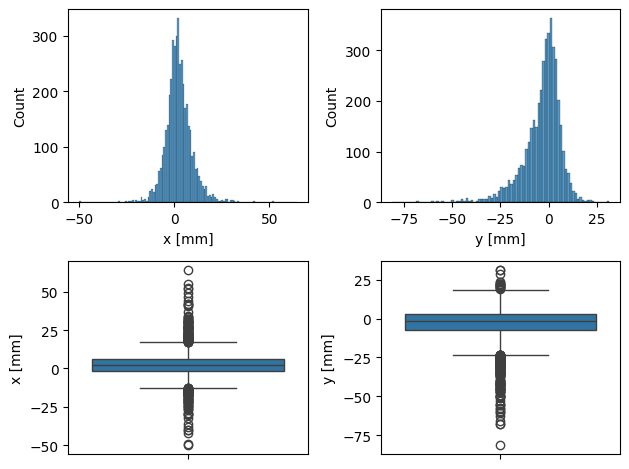



Schiefe x:  0.47799977909829416
Kurtosis x:  6.974256571406215 

Schiefe y:  -1.6307624425958709
Kurtosis y:  5.520592509234252 

Shapiro-Test x:  ShapiroResult(statistic=0.9246698021888733, pvalue=4.1492447528657833e-42)
Shapiro-Test y:  ShapiroResult(statistic=0.8934934139251709, pvalue=0.0)
Levene-Test x-y:  LeveneResult(statistic=158.75959899816797, pvalue=4.385520015643637e-36) 



In [ ]:
fig, axes = plt.subplots(2, 2)
sb.histplot(df_final["x [mm]"], ax=axes[0, 0])
sb.histplot(df_final["y [mm]"], ax=axes[0, 1])

sb.boxplot(df_final["x [mm]"], ax=axes[1, 0])
sb.boxplot(df_final["y [mm]"], ax=axes[1, 1])

plt.tight_layout()
plt.show()
print("\n")

print("Schiefe x: ", stats.skew(df_final["x [mm]"]))
print("Kurtosis x: ", stats.kurtosis(df_final["x [mm]"]), "\n")

print("Schiefe y: ", stats.skew(df_final["y [mm]"]))
print("Kurtosis y: ", stats.kurtosis(df_final["y [mm]"]), "\n")

print("Shapiro-Test x: ", stats.shapiro(df_final["x [mm]"]))
print("Shapiro-Test y: ", stats.shapiro(df_final["y [mm]"]))
print("Levene-Test x-y: ", stats.levene(df_final["x [mm]"], df_final["y [mm]"]), "\n")

In CSV-Datei abspeichern, damit wir später immer wieder drauf zurückgreifen können:

In [ ]:
from google.colab import files
df_final.to_csv('zv_final_data.csv')
files.download('zv_final_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Ab hier kann wieder ausgeführt werden

**5. Inferenzstatistische Tests**

Gruppenvergleiche:

In [3]:
df_final = pd.read_csv('/content/HammerProjekt/Ergebnisse/zv_final_data.csv')

df_final.rename(columns={'x [mm]': 'x'}, inplace = True)
df_final.rename(columns={'y [mm]': 'y'}, inplace = True)
df_final.rename(columns={'distance [mm]': 'distance'}, inplace = True)

df_final["position"] = df_final["position"].astype("object")
df_final["series"] = df_final["series"].astype("object")
df_final["Participant"] = df_final["Participant"].astype("object")


manova = MANOVA.from_formula("mode + series + mode:series + mode:position ~ x + y", data=df_final)

print(manova.mv_test())

                                   Multivariate linear model
                                                                                               
-----------------------------------------------------------------------------------------------
       Intercept                Value          Num DF   Den DF          F Value          Pr > F
-----------------------------------------------------------------------------------------------
          Wilks' lambda               -0.0000 14.0000 4298.0000 -276521017120548800.0000 1.0000
         Pillai's trace                1.0000 14.0000 4298.0000 -276521017120548768.0000 1.0000
 Hotelling-Lawley trace -900719925474100.2500 14.0000 4298.0000 -276521017120548768.0000 1.0000
    Roy's greatest root -900719925474100.2500 14.0000 4298.0000 -276521017120548768.0000 1.0000
-----------------------------------------------------------------------------------------------
                                                                           

-> hoch signifikantes Ergebnis aber quasi kaum Effekt (siehe Wilk's lambda, je kleiner desto größerer Effekt). Daher zusätzlich Mittelwertsvergleich:

In [4]:
df_final_means = df_final.groupby(["Participant", "mode", "position", "series"], as_index=False).mean(numeric_only=True)

manova_means = MANOVA.from_formula("mode + series + mode:series + mode:position ~ x + y", data=df_final_means)

print(manova_means.mv_test())

                                 Multivariate linear model
                                                                                            
--------------------------------------------------------------------------------------------
       Intercept                Value         Num DF  Den DF          F Value         Pr > F
--------------------------------------------------------------------------------------------
          Wilks' lambda               -0.0000 6.0000 784.0000 -84067193044249392.0000 1.0000
         Pillai's trace                1.0000 6.0000 784.0000 -84067193044249376.0000 1.0000
 Hotelling-Lawley trace -643371375338643.2500 6.0000 784.0000 -84067193044249360.0000 1.0000
    Roy's greatest root -643371375338643.2500 6.0000 784.0000 -84067193044249376.0000 1.0000
--------------------------------------------------------------------------------------------
                                                                                            
-----------

**Post-hoc Analysen:**

Da wir von ungleichen Varianzen ausgehen, nehmen wir den Games-Howell-Test für Post-hoc Analysen (siehe Field (2018))
-> nur für unabhängige Stichproben! Für abhängige Stichproben nehmen wir Wilcoxon-Tests (aus Ermangelung an Alternativen)

In [5]:
print("_______________________Position:_______________________")

one_posthoc = df_final.loc[df_final["position"] == 1.0]
two_posthoc = df_final.loc[df_final["position"] == 2.0]
three_posthoc = df_final.loc[df_final["position"] == 3.0]
four_posthoc = df_final.loc[df_final["position"] == 4.0]
five_posthoc = df_final.loc[df_final["position"] == 5.0]
six_posthoc = df_final.loc[df_final["position"] == 6.0]


print("Position 1: ")
print("x: ")
print(pairwise_gameshowell(one_posthoc, dv='x', between="mode"), "\n")
print("y: ")
print(pairwise_gameshowell(one_posthoc, dv='y', between="mode"), "\n")

print("Position 2: ")
print("x: ")
print(pairwise_gameshowell(two_posthoc, dv='x', between="mode"), "\n")
print("y: ")
print(pairwise_gameshowell(two_posthoc, dv='y', between="mode"), "\n")

print("Position 3:")
print("x: ")
print(pairwise_gameshowell(three_posthoc, dv='x', between="mode"), "\n")
print("y: ")
print(pairwise_gameshowell(three_posthoc, dv='y', between="mode"), "\n")

print("Position 4:")
print("x: ")
print(pairwise_gameshowell(four_posthoc, dv='x', between="mode"), "\n")
print("y: ")
print(pairwise_gameshowell(four_posthoc, dv='y', between="mode"), "\n")

print("Position 5:")
print("x: ")
print(pairwise_gameshowell(five_posthoc, dv='x', between="mode"), "\n")
print("y: ")
print(pairwise_gameshowell(five_posthoc, dv='y', between="mode"), "\n")

print("Position 6:")
print("x: ")
print(pairwise_gameshowell(six_posthoc, dv='x', between="mode"), "\n")
print("y: ")
print(pairwise_gameshowell(six_posthoc, dv='y', between="mode"), "\n\n")

posthoc_manova_means = MANOVA.from_formula("mode:position ~ x + y", data=df_final)
print(posthoc_manova_means.mv_test(skip_intercept_test=True), "\n\n")


print("_______________________Modus:_______________________")
print("x: ")
print(pairwise_gameshowell(df_final, dv='x', between="mode"), "\n")
print("y: ")
print(pairwise_gameshowell(df_final, dv='y', between="mode"), "\n")

print("_______________________Durchgang:_______________________")
vr_posthoc = df_final.loc[df_final["mode"] == "VR"]
real_posthoc = df_final.loc[df_final["mode"] == "Real"]

print("VR:")
print("x: ")
print(posthoc_wilcoxon(vr_posthoc, val_col="x", group_col="series"), "\n")
print("y: ")
print(posthoc_wilcoxon(vr_posthoc, val_col='y', group_col="series"), "\n\n")

print("Real:")
print("x: ")
print(posthoc_wilcoxon(real_posthoc, val_col="x", group_col="series"), "\n")
print("y: ")
print(posthoc_wilcoxon(real_posthoc, val_col='y', group_col="series"), "\n\n")

posthoc_manova = MANOVA.from_formula("series:mode ~ x + y", data=df_final)
print(posthoc_manova.mv_test(skip_intercept_test=True))


print("Mittelwerte VR")
print(vr_posthoc.groupby("series", as_index=False)[["x","y"]].mean(numeric_only=True), "\n")
print("Mittelwerte Real")
print(real_posthoc.groupby("series", as_index=False)[["x","y"]].mean(numeric_only=True))

_______________________Position:_______________________
Position 1: 
x: 
      A   B   mean(A)   mean(B)     diff        se         T          df  \
0  Real  VR  1.688242  2.593712 -0.90547  0.572552 -1.581465  539.195627   

       pval    hedges  
0  0.114358 -0.121167   

y: 
      A   B   mean(A)   mean(B)     diff        se         T          df  \
0  Real  VR -0.400206 -4.384246  3.98404  0.809157  4.923691  464.084642   

       pval   hedges  
0  0.000001  0.37874   

Position 2: 
x: 
      A   B   mean(A)   mean(B)      diff        se         T          df  \
0  Real  VR  2.390498  1.743579  0.646919  0.534968  1.209266  551.288783   

       pval    hedges  
0  0.227079  0.090853   

y: 
      A   B   mean(A)   mean(B)      diff        se        T         df  \
0  Real  VR -0.557098 -5.840333  5.283235  0.846725  6.23961  464.44095   

           pval    hedges  
0  9.889233e-10  0.471046   

Position 3:
x: 
      A   B  mean(A)   mean(B)      diff        se         T        

Und jetzt nochmal Post-hoc Vergleiche von Mittelwerten:

In [6]:
print("_______________________Position:_______________________")
one_mean_posthoc = df_final_means.loc[df_final_means["position"] == 1.0]
two_mean_posthoc = df_final_means.loc[df_final_means["position"] == 2.0]
three_mean_posthoc = df_final_means.loc[df_final_means["position"] == 3.0]
four_mean_posthoc = df_final_means.loc[df_final_means["position"] == 4.0]
five_mean_posthoc = df_final_means.loc[df_final_means["position"] == 5.0]
six_mean_posthoc = df_final_means.loc[df_final_means["position"] == 6.0]


print("Position 1: ")
print("x: ")
print(pairwise_gameshowell(one_mean_posthoc, dv='x', between="mode"), "\n")
print("y: ")
print(pairwise_gameshowell(one_mean_posthoc, dv='y', between="mode"), "\n")

print("Position 2: ")
print("x: ")
print(pairwise_gameshowell(two_mean_posthoc, dv='x', between="mode"), "\n")
print("y: ")
print(pairwise_gameshowell(two_mean_posthoc, dv='y', between="mode"), "\n")

print("Position 3:")
print("x: ")
print(pairwise_gameshowell(three_mean_posthoc, dv='x', between="mode"), "\n")
print("y: ")
print(pairwise_gameshowell(three_mean_posthoc, dv='y', between="mode"), "\n")

print("Position 4:")
print("x: ")
print(pairwise_gameshowell(four_mean_posthoc, dv='x', between="mode"), "\n")
print("y: ")
print(pairwise_gameshowell(four_mean_posthoc, dv='y', between="mode"), "\n")

print("Position 5:")
print("x: ")
print(pairwise_gameshowell(five_mean_posthoc, dv='x', between="mode"), "\n")
print("y: ")
print(pairwise_gameshowell(five_mean_posthoc, dv='y', between="mode"), "\n")

print("Position 6:")
print("x: ")
print(pairwise_gameshowell(six_mean_posthoc, dv='x', between="mode"), "\n")
print("y: ")
print(pairwise_gameshowell(six_mean_posthoc, dv='y', between="mode"), "\n\n")


posthoc_manova_means = MANOVA.from_formula("position:mode ~ x + y", data=df_final_means)
print(posthoc_manova_means.mv_test(skip_intercept_test=True), "\n")


print("_______________________Modus:_______________________")
print("x: ")
print(pairwise_gameshowell(df_final_means, dv='x', between="mode"), "\n")
print("y: ")
print(pairwise_gameshowell(df_final_means, dv='y', between="mode"), "\n\n")


print("_______________________Durchgang:_______________________")
vr_posthoc_mean = df_final.loc[df_final["mode"] == "VR"].groupby(["Participant", "series"], as_index=False).mean(numeric_only=True)
real_posthoc_mean = df_final.loc[df_final["mode"] == "Real"].groupby(["Participant", "series"], as_index=False).mean(numeric_only=True)

print("VR:")
print("x: ")
print(posthoc_wilcoxon(vr_posthoc_mean, val_col="x", group_col="series"), "\n")
print("y: ")
print(posthoc_wilcoxon(vr_posthoc_mean, val_col='y', group_col="series"), "\n\n")

print("Real:")
print("x: ")
print(posthoc_wilcoxon(real_posthoc_mean, val_col="x", group_col="series"), "\n")
print("y: ")
print(posthoc_wilcoxon(real_posthoc_mean, val_col='y', group_col="series"), "\n\n")

_______________________Position:_______________________
Position 1: 
x: 
      A   B   mean(A)   mean(B)      diff        se         T         df  \
0  Real  VR  1.686288  2.606629 -0.920341  0.945898 -0.972982  94.064783   

       pval    hedges  
0  0.333058 -0.168395   

y: 
      A   B   mean(A)   mean(B)      diff        se         T         df  \
0  Real  VR -0.372768 -4.470827  4.098059  1.522348  2.691933  81.585683   

       pval    hedges  
0  0.008617  0.465897   

Position 2: 
x: 
      A   B   mean(A)  mean(B)      diff        se         T         df  \
0  Real  VR  2.385156  1.68367  0.701487  0.782966  0.895935  94.121895   

       pval    hedges  
0  0.372573  0.155061   

y: 
      A   B  mean(A)   mean(B)      diff        se         T         df  \
0  Real  VR -0.76295 -6.252477  5.489527  1.721801  3.188246  77.682255   

       pval    hedges  
0  0.002064  0.551794   

Position 3:
x: 
      A   B   mean(A)   mean(B)      diff        se         T         df  \
0 

**4. Vergleiche innerhalb der Person**

In [7]:
significant_x = 0
significant_y = 0
significant_one_position_x = 0
significant_one_position_y = 0
significant_two_position_x = 0
significant_two_position_y = 0
significant_three_position_x = 0
significant_three_position_y = 0
significant_four_position_x = 0
significant_four_position_y = 0
significant_five_position_x = 0
significant_five_position_y = 0
significant_six_position_x = 0
significant_six_position_y = 0
significant_vr_series_x = 0
significant_real_series_x = 0
significant_vr_series_y = 0
significant_real_series_y = 0

for index, data, in df_final[["Participant", "position", "mode", "series", "x", "y", "distance"]].groupby("Participant", as_index=False):
    print("Versuchsperson {}: ".format(int(index)))

    data_vp_final = df_final[["Participant", "position", "mode", "series", "x", "y", "distance"]].loc[df_final["Participant"] == index].groupby(["mode", "position", "series"], as_index=False, group_keys=True)
    data_vp_final = data_vp_final.apply(lambda x: x)
    manova_vp = MANOVA.from_formula("position + mode + series + mode:series ~ x + y", data=data).mv_test(skip_intercept_test=True)

    x = pd.DataFrame((manova_vp.results['x']['stat']))
    y = pd.DataFrame((manova_vp.results['y']['stat']))

    results_dict = {"x": x, "y": y}

    for var in results_dict:
      if results_dict[var]["Pr > F"][0] < 0.05:
        print("Variable", var, "signifikant, p =", results_dict[var]["Pr > F"][0])

        one_mean_vp_posthoc = data_vp_final.loc[data_vp_final["position"] == 1.0]
        two_mean_vp_posthoc = data_vp_final.loc[data_vp_final["position"] == 2.0]
        three_mean_vp_posthoc = data_vp_final.loc[data_vp_final["position"] == 3.0]
        four_mean_vp_posthoc = data_vp_final.loc[data_vp_final["position"] == 4.0]
        five_mean_vp_posthoc = data_vp_final.loc[data_vp_final["position"] == 5.0]
        six_mean_vp_posthoc = data_vp_final.loc[data_vp_final["position"] == 6.0]


        # Da wir mit Mittelwerten arbeiten und hier nur ein Wert pro Durchgang herauskommt, können wir den Durchgang pro jeweilige VP nicht berechnen
        vr_vp_posthoc = data_vp_final.loc[data_vp_final["mode"] == "VR"]
        real_vp_posthoc = data_vp_final.loc[data_vp_final["mode"] == "Real"]


        # Falls genaue Ergebnisse pro VP gewünscht, bitte die Kommentare in diesem Block entfernen (die '''# vor und hinter den Ausdrücken entfernen)
        # (der Ausdruck wird sonst ewig lang)
        '''
        print("Posthoc: ")
        print("Positionen:")
        print("1:")
        print(var, ":")
        print(pairwise_gameshowell(one_mean_vp_posthoc, dv=var, between="mode"), "\n")

        print("2:")
        print(var, ":")
        print(pairwise_gameshowell(two_mean_vp_posthoc, dv=var, between="mode"), "\n")

        print("3:")
        print(var, ":")
        print(pairwise_gameshowell(three_mean_vp_posthoc, dv=var, between="mode"), "\n")

        print("4:")
        print(var, ":")
        print(pairwise_gameshowell(four_mean_vp_posthoc, dv=var, between="mode"), "\n")

        print("5:")
        print(var, ":")
        print(pairwise_gameshowell(five_mean_vp_posthoc, dv=var, between="mode"), "\n")

        print("6:")
        print(var, ":")
        print(pairwise_gameshowell(six_mean_vp_posthoc, dv=var, between="mode"), "\n")

        print(pairwise_gameshowell(data_vp_final, dv=var, between="mode"), "\n")

        print("VR:")
        print(var, ":")
        print(posthoc_wilcoxon(vr_vp_posthoc, val_col=var, group_col="series"), "\n")

        print("Real:")
        print(var, ":")
        print(posthoc_wilcoxon(real_vp_posthoc, val_col=vr, group_col="series"), "\n")

        posthoc_manova = MANOVA.from_formula("series:mode ~ x + y + distance", data=df_final)
        print(posthoc_manova.mv_test(skip_intercept_test=True))
        '''

        if var == "x":
          significant_x += 1
          significant_one_position_x += 1 if pairwise_gameshowell(one_mean_vp_posthoc, dv=var, between="mode").pval[0] < 0.05 else 0
          significant_two_position_x += 1 if pairwise_gameshowell(two_mean_vp_posthoc, dv=var, between="mode").pval[0] < 0.05 else 0
          significant_three_position_x += 1 if pairwise_gameshowell(three_mean_vp_posthoc, dv=var, between="mode").pval[0] < 0.05 else 0
          significant_four_position_x += 1 if pairwise_gameshowell(four_mean_vp_posthoc, dv=var, between="mode").pval[0] < 0.05 else 0
          significant_five_position_x += 1 if pairwise_gameshowell(five_mean_vp_posthoc, dv=var, between="mode").pval[0] < 0.05 else 0
          significant_six_position_x += 1 if pairwise_gameshowell(six_mean_vp_posthoc, dv=var, between="mode").pval[0] < 0.05 else 0
          significant_vr_series_x += 1 if posthoc_wilcoxon(vr_vp_posthoc, val_col=var, group_col="series").iloc[0, 1] < 0.05 else 0
          significant_real_series_x += 1 if posthoc_wilcoxon(real_vp_posthoc, val_col=var, group_col="series").iloc[0, 1] < 0.05 else 0
        elif var == "y":
          significant_y += 1
          significant_one_position_y += 1 if pairwise_gameshowell(one_mean_vp_posthoc, dv=var, between="mode").pval[0] < 0.05 else 0
          significant_two_position_y += 1 if pairwise_gameshowell(two_mean_vp_posthoc, dv=var, between="mode").pval[0] < 0.05 else 0
          significant_three_position_y += 1 if pairwise_gameshowell(three_mean_vp_posthoc, dv=var, between="mode").pval[0] < 0.05 else 0
          significant_four_position_y += 1 if pairwise_gameshowell(four_mean_vp_posthoc, dv=var, between="mode").pval[0] < 0.05 else 0
          significant_five_position_y += 1 if pairwise_gameshowell(five_mean_vp_posthoc, dv=var, between="mode").pval[0] < 0.05 else 0
          significant_six_position_y += 1 if pairwise_gameshowell(six_mean_vp_posthoc, dv=var, between="mode").pval[0] < 0.05 else 0
          significant_vr_series_y  += 1 if posthoc_wilcoxon(vr_vp_posthoc, val_col=var, group_col="series").iloc[0, 1] < 0.05 else 0
          significant_real_series_y += 1 if posthoc_wilcoxon(real_vp_posthoc, val_col=var, group_col="series").iloc[0, 1] < 0.05 else 0


    print("\n\n")

print("Anzahl signifikanter x-Werte:", significant_x)
print("Anzahl signifikanter y-Werte:", significant_y, "\n\n")
print("Anzahl signifikanter Positionswerte:")
print("1: ")
print("x:", significant_one_position_x)
print("y:", significant_one_position_y, "\n")
print("2: ")
print("x:", significant_two_position_x)
print("y:", significant_two_position_y, "\n")
print("3: ")
print("x:", significant_three_position_x)
print("y:", significant_three_position_y, "\n")
print("4: ")
print("x:", significant_four_position_x)
print("y:", significant_four_position_y, "\n")
print("5: ")
print("x:", significant_five_position_x)
print("y:", significant_five_position_y, "\n")
print("6: ")
print("x:", significant_six_position_x)
print("y:", significant_six_position_y, "\n\n")

print("Anzahl signifikanter Werte je Präsentationsmodus:")
print("VR:")
print("x:", significant_vr_series_x)
print("y:", significant_vr_series_y, "\n")
print("Real:")
print("x:", significant_real_series_x)
print("y:", significant_real_series_y, "\n")

Versuchsperson 1: 
Variable x signifikant, p = 6.342966532941216e-07
Variable y signifikant, p = 7.464539099010779e-13



Versuchsperson 2: 
Variable y signifikant, p = 0.00039087846088930024



Versuchsperson 3: 
Variable x signifikant, p = 2.933593945235381e-08
Variable y signifikant, p = 1.6878377837755898e-05



Versuchsperson 4: 
Variable x signifikant, p = 0.02307210800742237
Variable y signifikant, p = 0.0008233728543172204



Versuchsperson 5: 
Variable x signifikant, p = 0.00042990323685638236
Variable y signifikant, p = 7.191837322710659e-11



Versuchsperson 6: 
Variable x signifikant, p = 2.2988184467741357e-06
Variable y signifikant, p = 5.877423169350356e-24



Versuchsperson 7: 
Variable y signifikant, p = 1.056037773205042e-16



Versuchsperson 8: 
Variable x signifikant, p = 0.0004058201204144715
Variable y signifikant, p = 0.0019327858294414335



Versuchsperson 9: 



Versuchsperson 10: 
Variable x signifikant, p = 6.91868737838192e-08
Variable y signifikant, p = 1.1